# Coming from Nengo to NengoDL

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/from-nengo.ipynb)

NengoDL combines two frameworks: Nengo and TensorFlow.  This tutorial is designed for
people who are familiar with Nengo and looking to take advantage of the new features of
NengoDL.  For the other approach, users familiar with TensorFlow looking to learn how to
use NengoDL, check out [this
tutorial](https://www.nengo.ai/nengo-dl/examples/from-tensorflow.html).

## Simulating a network with NengoDL

We'll begin by defining a simple Nengo network to use as an example.  The goal of our
network will be to compute $sin(x^2)$.  There is nothing particularly significant about
this network or function; the same principles we will discuss here could be applied to
any Nengo model.

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import nengo
import numpy as np
import tensorflow as tf

import nengo_dl


warnings.simplefilter("ignore")
tf.get_logger().addFilter(lambda rec: "Tracing is expensive" not in rec.msg)

# we'll control the random seed in this example to make sure things stay
# consistent, but the results don't depend significantly on the seed
# (try changing it to verify)
seed = 0
np.random.seed(seed)

In [2]:
with nengo.Network(seed=seed) as net:
    # input node outputting a random signal for x
    inpt = nengo.Node(nengo.processes.WhiteSignal(1, 5, rms=0.3))

    # first ensemble, will compute x^2
    square = nengo.Ensemble(20, 1)

    # second ensemble, will compute sin(x^2)
    sin = nengo.Ensemble(20, 1)

    # output node
    outpt = nengo.Node(size_in=1)

    # connect everything together
    nengo.Connection(inpt, square)
    nengo.Connection(square, sin, function=np.square)
    nengo.Connection(sin, outpt, function=np.sin)

    # add a probe on the input and output
    inpt_p = nengo.Probe(inpt)
    outpt_p = nengo.Probe(outpt, synapse=0.01)

We can simulate this network in the regular Nengo simulator:

In [3]:
with nengo.Simulator(net, seed=seed) as sim:
    sim.run(1.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

And plot the output:

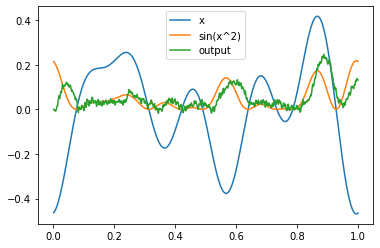

In [4]:
def plot(plot_sim, ax=None, idx=slice(None)):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    ax.plot(plot_sim.trange(), plot_sim.data[inpt_p][idx], label="x")
    ax.plot(
        plot_sim.trange(), np.sin(plot_sim.data[inpt_p][idx] ** 2), label="sin(x^2)"
    )
    ax.plot(plot_sim.trange(), plot_sim.data[outpt_p][idx], label="output")
    ax.legend()


plot(sim)

To run the same network in NengoDL, all we need to do is switch `nengo.Simulator` to
`nengo_dl.Simulator`:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|                         Constructing graph      #                   | 0:00:04

|                         Constructing graph              #           | 0:00:05

|                         Constructing graph               #          | 0:00:05

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#######       Constructing graph: build stage (11%)             | ETA: 0:00:00

|##############Constructing graph: build stage (44%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|                         Constructing graph                 #        | 0:00:06

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:06                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

| #                           Simulating                              | 0:00:00

|#######       Constructing graph: build stage (11%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|  #                          Simulating                              | 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

|          #                  Simulating                              | 0:00:01

|           #                 Simulating                              | 0:00:01

Simulation finished in 0:00:01                                                 

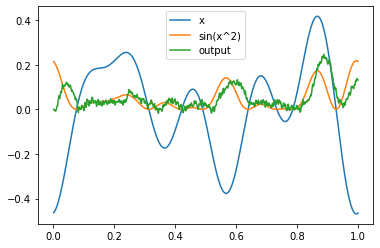

In [5]:
with nengo_dl.Simulator(net, seed=seed) as sim:
    sim.run(1.0)

plot(sim)

Note that the output of the NengoDL simulator is the same as the standard Nengo
simulator.  Switching to NengoDL will not impact the behaviour of a model at all
(ignoring very minor floating point math differences); any model that can run in Nengo
will also run in NengoDL and produce the same output.

However, NengoDL adds a number of new features on top of the standard Nengo simulator,
which we will explore next.

## Batch processing

Often when testing a model we want to run it several times with different input values.
In regular Nengo we can achieve this by calling `sim.run` several times, resetting
between each run:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

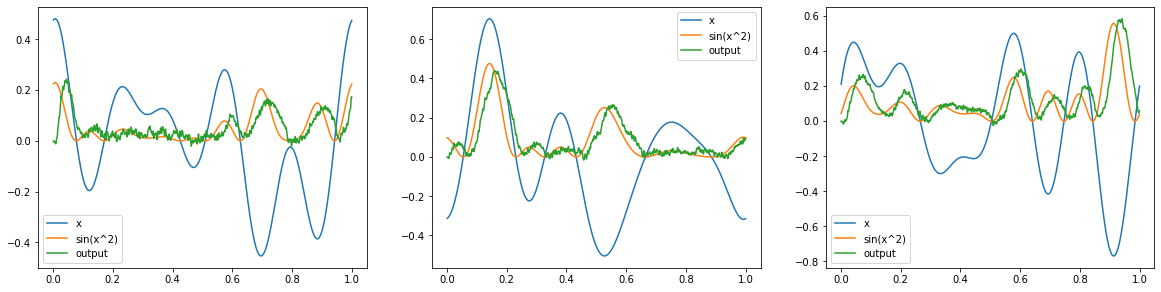

In [6]:
reps = 3

with nengo.Simulator(net) as sim:
    _, axes = plt.subplots(1, reps, figsize=(20, 4.8))
    for i in range(reps):
        sim.run(1.0)
        plot(sim, ax=axes[i])

        sim.reset(seed=i + 10)

Note that simulating `n` different input sequences in this way takes `n` times as long
as a single input sequence.

NengoDL, on the other hand, allows us to run several input values through the network in
parallel.  This is known as "batch processing".  This can significantly improve the
simulation time, as we can parallelize the computations and achieve much better than
linear scaling.

This is controlled through the `minibatch_size` parameter of the NengoDL simulator.  To
accomplish the same thing as above, but with a single parallelized call to `sim.run`, we
can do:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#######       Constructing graph: build stage (11%)             | ETA: 0:00:00

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|  #                      Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

| #                           Simulating                              | 0:00:00

|#######       Constructing graph: build stage (11%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|  #                          Simulating                              | 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

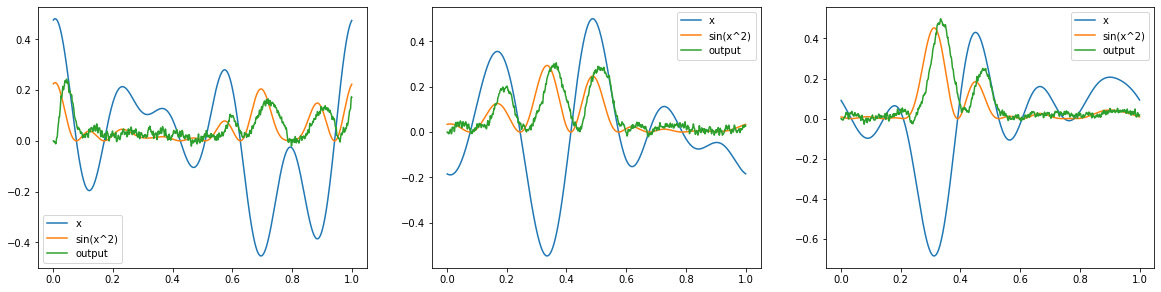

In [7]:
with nengo_dl.Simulator(net, minibatch_size=reps) as sim:
    sim.run(1.0)

_, axes = plt.subplots(1, reps, figsize=(20, 4.8))
for i in range(reps):
    plot(sim, ax=axes[i], idx=i)

Note that in this case the inputs and outputs aren't matching between the two simulators
because we're not worrying about controlling the random seed.  But we can see that the
network has run three different simulations in a single parallel run.

## Specifying model inputs at run time

In standard Nengo, input values are specified in the model definition (when we create a
`nengo.Node`).  At run time, the model is then simulated with those input values every
time; if we want to change the input values, we need to change the `Node`.  However, it
can be useful to dynamically specify the input values at run time, so that we can
simulate the model with different input values without changing our model definition.

NengoDL supports this through the `data` argument.  This is a dictionary that maps Nodes
to arrays, where each array has shape `(minibatch_size, n_steps, node_size)`.
`minibatch_size` refers to the `Simulator.minibatch_size` parameter discussed in the
previous section, `n_steps` is the number of simulation time steps, and `node_size` is
the output dimensionality of the `Node`.

For example, we could simulate our network with a linear ramp input:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (22%)             | ETA: 0:00:00

|##############Constructing graph: build stage (44%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|  #                      Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#######       Constructing graph: build stage (11%)             | ETA: 0:00:00

| #                           Simulating                              | 0:00:00

|##############Constructing graph: build stage (44%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|  #                          Simulating                              | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

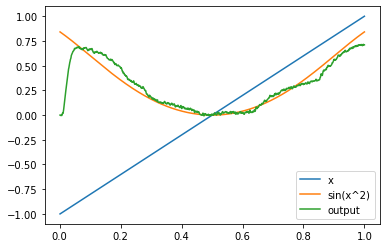

In [8]:
with nengo_dl.Simulator(net) as sim:
    sim.run(1.0, data={inpt: np.reshape(np.linspace(-1, 1, 1000), (1, 1000, 1))})

plot(sim)

Note that we didn't change the model definition at all.  In theory, our Node is still
outputting the same random signal, but we overrode that with the values in `data`.

This functionality is particularly useful in concert with batch processing, as it allows
us to provide different input values for each item in the batch.  For example, we could
run each batch item with a different ramp input:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (22%)             | ETA: 0:00:00

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

|  #                      Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#######       Constructing graph: build stage (11%)             | ETA: 0:00:00

| #                           Simulating                              | 0:00:00

|##############Constructing graph: build stage (66%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|  #                          Simulating                              | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

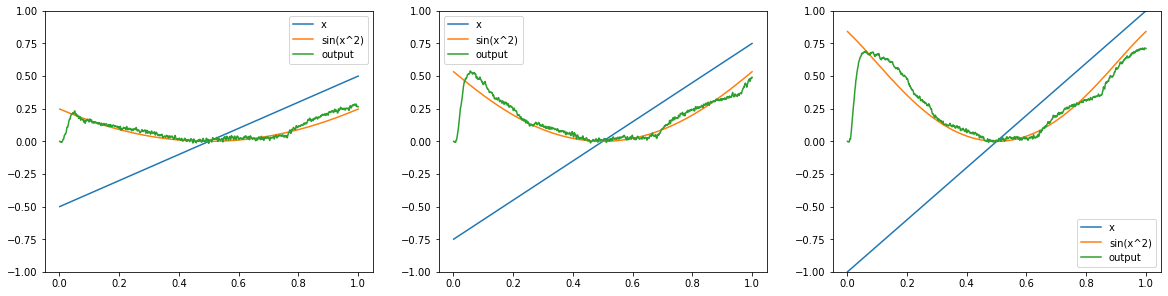

In [9]:
with nengo_dl.Simulator(net, minibatch_size=reps) as sim:
    sim.run(
        1.0,
        data={
            inpt: (
                np.linspace(0.5, 1, reps)[:, None, None]
                * np.linspace(-1, 1, 1000)[None, :, None]
            )
        },
    )

_, axes = plt.subplots(1, reps, figsize=(20, 4.8))
for i in range(reps):
    plot(sim, ax=axes[i], idx=i)
    axes[i].set_ylim((-1, 1))

## Optimizing model parameters

By default, Nengo uses the [Neural Engineering
Framework](http://compneuro.uwaterloo.ca/research/nef.html) to optimize the parameters
of a model.  NengoDL adds a new set of optimization tools (deep learning training
methods) to that toolkit, which can be used instead of or in addition to the NEF
optimization.

Which techniques work best will depend on the particular model being developed.
However, as a general rule of thumb the deep learning methods will tend to take longer
but provide more accurate network output.  One reason for this is that deep learning
methods can jointly optimize across all the parameters in the network (e.g., adjusting
the decoders for multiple chained connections so that they work together to compute a
function), whereas the NEF optimization is applied to each connection individually.
Deep learning methods can also optimize all the parameters in a network (encoders,
decoders, and biases), whereas NEF methods are only applied to decoders.  We'll
illustrate this difference in this example by using a hybrid approach, where we use the
NEF to compute the decoders and deep learning methods to optimize encoders and biases.

First we're going to make some changes to the model itself.  We created the model with
the default synaptic filter of `nengo.Lowpass(tau=0.005)` on all the Connections.  This
makes sense when we're working with a spiking model, as the filters reduce the spike
noise in the communication between Ensembles.  However, when we're training a network in
NengoDL the synaptic filters introduce more complex temporal dynamics into the
optimization problem.  This is not necessarily a bad thing, as those temporal dynamics
may be something we care about and want to optimize for.  But in this instance we don't
particularly care about the synaptic dynamics.  During training NengoDL will
automatically be swapping the spiking `nengo.LIF` neuron model for the non-spiking
`nengo.LIFRate`, so we don't need the synaptic filters to reduce spike noise.  And
because this is a simple feedforward network, there aren't any other temporal dynamics
in the system that the synaptic filtering would interact with.  So we can simplify our
optimization problem by removing the synaptic filters, without significantly changing
the behaviour of our model.

In [10]:
# set all the connection synapses to None
for conn in net.all_connections:
    conn.synapse = None

# add a new probe that doesn't have a synaptic filter on it
# (we'll keep the original probe with the synaptic filter
# as well, since we'll have uses for both)
with net:
    outpt_p_nofilt = nengo.Probe(outpt)

# increase the filtering on our output probe (to compensate
# for the fact that we removed the internal synaptic filters)
outpt_p.synapse = 0.04

We can verify that our network still produces roughly the same output after these
changes.

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|##############Constructing graph: build stage (26%)             | ETA: 0:00:00

|##############Constructing graph: build stage (53%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|########      Constructing graph: build stage (13%)             | ETA: 0:00:00

| #                           Simulating                              | 0:00:00

|##############Constructing graph: build stage (46%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|  #                          Simulating                              | 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

|          #                  Simulating                              | 0:00:01

|           #                 Simulating                              | 0:00:01

|            #                Simulating                              | 0:00:01

|             #               Simulating                              | 0:00:01

Simulation finished in 0:00:01                                                 

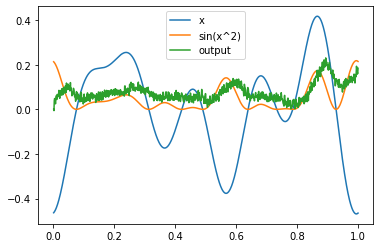

In [11]:
with nengo_dl.Simulator(net, seed=seed) as sim:
    sim.run(1.0)
    plot(sim)

Next we will select how we want to optimize this network.  As discussed above, in this
example we're going to leave the decoders the same, and apply our deep learning
optimization to the encoders and biases.  We can control which parts of a model will be
optimized through the `trainable` configuration attribute.  More details on how this
works can be found [in the
documentation](https://www.nengo.ai/nengo-dl/config.html#trainable).

In [12]:
with net:
    # disable optimization on all parameters by default
    nengo_dl.configure_settings(trainable=False)

    # re-enable training on Ensembles (encoders and biases)
    net.config[nengo.Ensemble].trainable = True

Next we need to define our training data.  This consists of two parts: input values for
Nodes, and target values for Probes.  These indicate that when the network receives the
given input values, we want to see the corresponding target values at the probe.  The
data is specified as a dictionary mapping nodes/probes to arrays.  This is much the same
as the `data` argument introduced above, and the arrays have a similar shape
`(batch_size, n_steps, node/probe_size)`.  Note that `batch_size` in this case can be
greater than `minibatch_size`, and the data will automatically be divided up into
`minibatch_size` chunks during training.

In this example `n_steps` will just be 1, meaning that we will only be optimizing the
model parameters with respect to a single timestep of inputs and outputs.  Because we
have eliminated the temporal dynamics in our model by removing the synaptic filters,
each timestep can be treated independently.  That is, training with a batch size of 1
for 1000 timesteps is the same as training with a batch size of 1000 for 1 timestep.
And the latter is preferred, as the computations will be more efficient when we can
divide them into minibatches and parallelize them.

Note that if our model had temporal dynamics (e.g., through recurrent connections or
synaptic filters) then it would be important to train with `n_steps>1`, in order to
capture those dynamics.  But we don't need to worry about that in this case, nor in many
common deep-learning-style networks, so we'll keep things simple.  See [this
example](https://www.nengo.ai/nengo-dl/examples/spa-memory) for a more complex problem
where temporal dynamics are involved.

In [13]:
batch_size = 4096
minibatch_size = 32
n_steps = 1

# create random input data
vals = np.random.uniform(-1, 1, size=(batch_size, n_steps, 1))

# create data dictionaries
inputs = {inpt: vals}
targets = {outpt_p_nofilt: np.sin(vals ** 2)}

Now we are ready to optimize our model.  This is done through the `sim.compile` and
`sim.fit` functions.  In addition to the `inputs/targets`, there are three more
arguments we need to think about.

The first is which deep learning optimization algorithm we want to use when training the
network.  Essentially these algorithms define how to turn an error value into a change
in the model parameters (with the goal being to reduce the error).  There are [many
options available](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers),
which we will not go into here.  We'll use RMSProp, which is a decent default in many
cases.

Second, we need to think about the objective function.  This is the function that
computes an error value given the network outputs (for example, by computing the
difference between the output and target values).  Again there are [many options
here](https://www.tensorflow.org/api_docs/python/tf/keras/losses) that we will not go
into; choosing an appropriate objective function depends on the nature of a particular
task.  In this example we will use mean squared error, which is generally a good
default.

The third parameter we'll set is `epochs`.  This determines how many training iterations
we will execute; one epoch is one complete pass through the training data.  This is a
parameter that generally needs to be set through trial and error; it will depend on the
particular optimization task.

See [the documentation](https://www.nengo.ai/nengo-dl/simulator.html) for a more
in-depth discussion of `sim.fit` parameters and usage.

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|##############Constructing graph: build stage (26%)             | ETA: 0:00:00

|##############Constructing graph: build stage (53%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|  #                      Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/25


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|##############Constructing graph: build stage (53%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|##############Constructing graph: build stage (53%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

  1/128 [..............................] - ETA: 0s - loss: 0.0014 - probe_2_loss: 0.0014

 11/128 [=>............................] - ETA: 0s - loss: 0.0019 - probe_2_loss: 0.0019

 22/128 [====>.........................] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

 34/128 [======>.......................] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

 44/128 [=========>....................] - ETA: 0s - loss: 0.0016 - probe_2_loss: 0.0016

 55/128 [===========>..................] - ETA: 0s - loss: 0.0016 - probe_2_loss: 0.0016

 66/128 [==============>...............] - ETA: 0s - loss: 0.0016 - probe_2_loss: 0.0016

 77/128 [=================>............] - ETA: 0s - loss: 0.0016 - probe_2_loss: 0.0016

 88/128 [===================>..........] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

 99/128 [======================>.......] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

111/128 [=========================>....] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

122/128 [===========================>..] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

128/128 [==============================] - 1s 5ms/step - loss: 0.0015 - probe_2_loss: 0.0015


Epoch 2/25
  1/128 [..............................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

  7/128 [>.............................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

 18/128 [===>..........................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 29/128 [=====>........................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 39/128 [========>.....................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 51/128 [==========>...................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 62/128 [=============>................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 73/128 [================>.............] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 84/128 [==================>...........] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 95/128 [=====================>........] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

105/128 [=======================>......] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

116/128 [==========================>...] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

125/128 [============================>.] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

128/128 [==============================] - 1s 5ms/step - loss: 0.0011 - probe_2_loss: 0.0011


Epoch 3/25
  1/128 [..............................] - ETA: 0s - loss: 0.0010 - probe_2_loss: 0.0010

 12/128 [=>............................] - ETA: 0s - loss: 9.0925e-04 - probe_2_loss: 9.0925e-04

 23/128 [====>.........................] - ETA: 0s - loss: 9.6714e-04 - probe_2_loss: 9.6714e-04

 34/128 [======>.......................] - ETA: 0s - loss: 9.2279e-04 - probe_2_loss: 9.2279e-04

 45/128 [=========>....................] - ETA: 0s - loss: 9.5045e-04 - probe_2_loss: 9.5045e-04

 56/128 [============>.................] - ETA: 0s - loss: 9.3106e-04 - probe_2_loss: 9.3106e-04

 67/128 [==============>...............] - ETA: 0s - loss: 9.1139e-04 - probe_2_loss: 9.1139e-04

 74/128 [================>.............] - ETA: 0s - loss: 9.1602e-04 - probe_2_loss: 9.1602e-04

 86/128 [===================>..........] - ETA: 0s - loss: 9.1598e-04 - probe_2_loss: 9.1598e-04

 94/128 [=====================>........] - ETA: 0s - loss: 9.1295e-04 - probe_2_loss: 9.1295e-04

105/128 [=======================>......] - ETA: 0s - loss: 8.9635e-04 - probe_2_loss: 8.9635e-04

116/128 [==========================>...] - ETA: 0s - loss: 8.7691e-04 - probe_2_loss: 8.7691e-04

127/128 [============================>.] - ETA: 0s - loss: 8.7200e-04 - probe_2_loss: 8.7200e-04

128/128 [==============================] - 1s 5ms/step - loss: 8.7136e-04 - probe_2_loss: 8.7136e-04


Epoch 4/25
  1/128 [..............................] - ETA: 0s - loss: 4.7493e-04 - probe_2_loss: 4.7493e-04

 12/128 [=>............................] - ETA: 0s - loss: 6.3250e-04 - probe_2_loss: 6.3250e-04

 23/128 [====>.........................] - ETA: 0s - loss: 7.1409e-04 - probe_2_loss: 7.1409e-04

 34/128 [======>.......................] - ETA: 0s - loss: 7.1230e-04 - probe_2_loss: 7.1230e-04

 45/128 [=========>....................] - ETA: 0s - loss: 7.7211e-04 - probe_2_loss: 7.7211e-04

 56/128 [============>.................] - ETA: 0s - loss: 7.7537e-04 - probe_2_loss: 7.7537e-04

 67/128 [==============>...............] - ETA: 0s - loss: 7.6402e-04 - probe_2_loss: 7.6402e-04

 78/128 [=================>............] - ETA: 0s - loss: 7.5288e-04 - probe_2_loss: 7.5288e-04

 88/128 [===================>..........] - ETA: 0s - loss: 7.4540e-04 - probe_2_loss: 7.4540e-04

 99/128 [======================>.......] - ETA: 0s - loss: 7.2967e-04 - probe_2_loss: 7.2967e-04

111/128 [=========================>....] - ETA: 0s - loss: 7.2721e-04 - probe_2_loss: 7.2721e-04

121/128 [===========================>..] - ETA: 0s - loss: 7.1971e-04 - probe_2_loss: 7.1971e-04

128/128 [==============================] - 1s 5ms/step - loss: 7.1509e-04 - probe_2_loss: 7.1509e-04


Epoch 5/25
  1/128 [..............................] - ETA: 0s - loss: 7.6410e-04 - probe_2_loss: 7.6410e-04

 13/128 [==>...........................] - ETA: 0s - loss: 6.8703e-04 - probe_2_loss: 6.8703e-04

 25/128 [====>.........................] - ETA: 0s - loss: 6.8533e-04 - probe_2_loss: 6.8533e-04

 36/128 [=======>......................] - ETA: 0s - loss: 6.5986e-04 - probe_2_loss: 6.5986e-04

 47/128 [==========>...................] - ETA: 0s - loss: 6.6722e-04 - probe_2_loss: 6.6722e-04

 59/128 [============>.................] - ETA: 0s - loss: 6.5110e-04 - probe_2_loss: 6.5110e-04

 71/128 [===============>..............] - ETA: 0s - loss: 6.4600e-04 - probe_2_loss: 6.4600e-04

 82/128 [==================>...........] - ETA: 0s - loss: 6.4683e-04 - probe_2_loss: 6.4683e-04

 93/128 [====================>.........] - ETA: 0s - loss: 6.4370e-04 - probe_2_loss: 6.4370e-04

105/128 [=======================>......] - ETA: 0s - loss: 6.2567e-04 - probe_2_loss: 6.2567e-04

116/128 [==========================>...] - ETA: 0s - loss: 6.1798e-04 - probe_2_loss: 6.1798e-04

127/128 [============================>.] - ETA: 0s - loss: 6.1676e-04 - probe_2_loss: 6.1676e-04

128/128 [==============================] - 1s 5ms/step - loss: 6.1673e-04 - probe_2_loss: 6.1673e-04


Epoch 6/25
  1/128 [..............................] - ETA: 0s - loss: 4.8645e-04 - probe_2_loss: 4.8645e-04

 13/128 [==>...........................] - ETA: 0s - loss: 4.9781e-04 - probe_2_loss: 4.9781e-04

 24/128 [====>.........................] - ETA: 0s - loss: 5.6467e-04 - probe_2_loss: 5.6467e-04

 35/128 [=======>......................] - ETA: 0s - loss: 5.5456e-04 - probe_2_loss: 5.5456e-04

 47/128 [==========>...................] - ETA: 0s - loss: 5.5080e-04 - probe_2_loss: 5.5080e-04

 58/128 [============>.................] - ETA: 0s - loss: 5.6026e-04 - probe_2_loss: 5.6026e-04

 70/128 [===============>..............] - ETA: 0s - loss: 5.6608e-04 - probe_2_loss: 5.6608e-04

 81/128 [=================>............] - ETA: 0s - loss: 5.7360e-04 - probe_2_loss: 5.7360e-04

 93/128 [====================>.........] - ETA: 0s - loss: 5.7375e-04 - probe_2_loss: 5.7375e-04

105/128 [=======================>......] - ETA: 0s - loss: 5.7211e-04 - probe_2_loss: 5.7211e-04

116/128 [==========================>...] - ETA: 0s - loss: 5.6414e-04 - probe_2_loss: 5.6414e-04

127/128 [============================>.] - ETA: 0s - loss: 5.5971e-04 - probe_2_loss: 5.5971e-04

128/128 [==============================] - 1s 5ms/step - loss: 5.5997e-04 - probe_2_loss: 5.5997e-04


Epoch 7/25
  1/128 [..............................] - ETA: 0s - loss: 5.4964e-04 - probe_2_loss: 5.4964e-04

 12/128 [=>............................] - ETA: 0s - loss: 5.4098e-04 - probe_2_loss: 5.4098e-04

 24/128 [====>.........................] - ETA: 0s - loss: 5.0796e-04 - probe_2_loss: 5.0796e-04

 35/128 [=======>......................] - ETA: 0s - loss: 5.1459e-04 - probe_2_loss: 5.1459e-04

 46/128 [=========>....................] - ETA: 0s - loss: 5.2507e-04 - probe_2_loss: 5.2507e-04

 57/128 [============>.................] - ETA: 0s - loss: 5.2224e-04 - probe_2_loss: 5.2224e-04

 68/128 [==============>...............] - ETA: 0s - loss: 5.2186e-04 - probe_2_loss: 5.2186e-04

 78/128 [=================>............] - ETA: 0s - loss: 5.4221e-04 - probe_2_loss: 5.4221e-04

 90/128 [====================>.........] - ETA: 0s - loss: 5.4274e-04 - probe_2_loss: 5.4274e-04

102/128 [======================>.......] - ETA: 0s - loss: 5.2842e-04 - probe_2_loss: 5.2842e-04

114/128 [=========================>....] - ETA: 0s - loss: 5.2733e-04 - probe_2_loss: 5.2733e-04

125/128 [============================>.] - ETA: 0s - loss: 5.2331e-04 - probe_2_loss: 5.2331e-04

128/128 [==============================] - 1s 5ms/step - loss: 5.2133e-04 - probe_2_loss: 5.2133e-04


Epoch 8/25
  1/128 [..............................] - ETA: 0s - loss: 6.3802e-04 - probe_2_loss: 6.3802e-04

 13/128 [==>...........................] - ETA: 0s - loss: 5.2330e-04 - probe_2_loss: 5.2330e-04

 24/128 [====>.........................] - ETA: 0s - loss: 5.2853e-04 - probe_2_loss: 5.2853e-04

 35/128 [=======>......................] - ETA: 0s - loss: 5.1721e-04 - probe_2_loss: 5.1721e-04

 47/128 [==========>...................] - ETA: 0s - loss: 5.0702e-04 - probe_2_loss: 5.0702e-04

 59/128 [============>.................] - ETA: 0s - loss: 5.1221e-04 - probe_2_loss: 5.1221e-04

 70/128 [===============>..............] - ETA: 0s - loss: 4.9928e-04 - probe_2_loss: 4.9928e-04

 81/128 [=================>............] - ETA: 0s - loss: 5.0451e-04 - probe_2_loss: 5.0451e-04

 93/128 [====================>.........] - ETA: 0s - loss: 5.0006e-04 - probe_2_loss: 5.0006e-04

105/128 [=======================>......] - ETA: 0s - loss: 5.0484e-04 - probe_2_loss: 5.0484e-04

117/128 [==========================>...] - ETA: 0s - loss: 5.0129e-04 - probe_2_loss: 5.0129e-04

128/128 [==============================] - ETA: 0s - loss: 4.9686e-04 - probe_2_loss: 4.9686e-04

128/128 [==============================] - 1s 5ms/step - loss: 4.9686e-04 - probe_2_loss: 4.9686e-04


Epoch 9/25
  1/128 [..............................] - ETA: 0s - loss: 2.5378e-04 - probe_2_loss: 2.5378e-04

 12/128 [=>............................] - ETA: 0s - loss: 4.5942e-04 - probe_2_loss: 4.5942e-04

 21/128 [===>..........................] - ETA: 0s - loss: 4.8905e-04 - probe_2_loss: 4.8905e-04

 32/128 [======>.......................] - ETA: 0s - loss: 5.1102e-04 - probe_2_loss: 5.1102e-04

 43/128 [=========>....................] - ETA: 0s - loss: 5.0559e-04 - probe_2_loss: 5.0559e-04

 55/128 [===========>..................] - ETA: 0s - loss: 5.0038e-04 - probe_2_loss: 5.0038e-04

 67/128 [==============>...............] - ETA: 0s - loss: 4.9467e-04 - probe_2_loss: 4.9467e-04

 78/128 [=================>............] - ETA: 0s - loss: 4.9430e-04 - probe_2_loss: 4.9430e-04

 90/128 [====================>.........] - ETA: 0s - loss: 4.8839e-04 - probe_2_loss: 4.8839e-04

102/128 [======================>.......] - ETA: 0s - loss: 4.8455e-04 - probe_2_loss: 4.8455e-04

113/128 [=========================>....] - ETA: 0s - loss: 4.7942e-04 - probe_2_loss: 4.7942e-04

125/128 [============================>.] - ETA: 0s - loss: 4.7948e-04 - probe_2_loss: 4.7948e-04

128/128 [==============================] - 1s 5ms/step - loss: 4.7630e-04 - probe_2_loss: 4.7630e-04


Epoch 10/25
  1/128 [..............................] - ETA: 0s - loss: 5.8436e-04 - probe_2_loss: 5.8436e-04

 13/128 [==>...........................] - ETA: 0s - loss: 3.8286e-04 - probe_2_loss: 3.8286e-04

 24/128 [====>.........................] - ETA: 0s - loss: 4.3654e-04 - probe_2_loss: 4.3654e-04

 36/128 [=======>......................] - ETA: 0s - loss: 4.4419e-04 - probe_2_loss: 4.4419e-04

 47/128 [==========>...................] - ETA: 0s - loss: 4.4247e-04 - probe_2_loss: 4.4247e-04

 59/128 [============>.................] - ETA: 0s - loss: 4.5426e-04 - probe_2_loss: 4.5426e-04

 71/128 [===============>..............] - ETA: 0s - loss: 4.6690e-04 - probe_2_loss: 4.6690e-04

 82/128 [==================>...........] - ETA: 0s - loss: 4.6453e-04 - probe_2_loss: 4.6453e-04

 93/128 [====================>.........] - ETA: 0s - loss: 4.6243e-04 - probe_2_loss: 4.6243e-04

104/128 [=======================>......] - ETA: 0s - loss: 4.5914e-04 - probe_2_loss: 4.5914e-04

115/128 [=========================>....] - ETA: 0s - loss: 4.5649e-04 - probe_2_loss: 4.5649e-04

126/128 [============================>.] - ETA: 0s - loss: 4.5501e-04 - probe_2_loss: 4.5501e-04

128/128 [==============================] - 1s 5ms/step - loss: 4.5687e-04 - probe_2_loss: 4.5687e-04


Epoch 11/25
  1/128 [..............................] - ETA: 0s - loss: 8.4476e-04 - probe_2_loss: 8.4476e-04

 13/128 [==>...........................] - ETA: 0s - loss: 4.7016e-04 - probe_2_loss: 4.7016e-04

 25/128 [====>.........................] - ETA: 0s - loss: 4.5164e-04 - probe_2_loss: 4.5164e-04

 37/128 [=======>......................] - ETA: 0s - loss: 4.3818e-04 - probe_2_loss: 4.3818e-04

 49/128 [==========>...................] - ETA: 0s - loss: 4.4205e-04 - probe_2_loss: 4.4205e-04

 61/128 [=============>................] - ETA: 0s - loss: 4.5353e-04 - probe_2_loss: 4.5353e-04

 73/128 [================>.............] - ETA: 0s - loss: 4.3927e-04 - probe_2_loss: 4.3927e-04

 84/128 [==================>...........] - ETA: 0s - loss: 4.4063e-04 - probe_2_loss: 4.4063e-04

 95/128 [=====================>........] - ETA: 0s - loss: 4.4566e-04 - probe_2_loss: 4.4566e-04

106/128 [=======================>......] - ETA: 0s - loss: 4.4237e-04 - probe_2_loss: 4.4237e-04

118/128 [==========================>...] - ETA: 0s - loss: 4.4300e-04 - probe_2_loss: 4.4300e-04

128/128 [==============================] - 1s 4ms/step - loss: 4.3958e-04 - probe_2_loss: 4.3958e-04


Epoch 12/25
  1/128 [..............................] - ETA: 0s - loss: 4.5329e-04 - probe_2_loss: 4.5329e-04

 12/128 [=>............................] - ETA: 0s - loss: 4.5725e-04 - probe_2_loss: 4.5725e-04

 24/128 [====>.........................] - ETA: 0s - loss: 4.1811e-04 - probe_2_loss: 4.1811e-04

 36/128 [=======>......................] - ETA: 0s - loss: 4.1988e-04 - probe_2_loss: 4.1988e-04

 47/128 [==========>...................] - ETA: 0s - loss: 4.2624e-04 - probe_2_loss: 4.2624e-04

 59/128 [============>.................] - ETA: 0s - loss: 4.2475e-04 - probe_2_loss: 4.2475e-04

 70/128 [===============>..............] - ETA: 0s - loss: 4.2270e-04 - probe_2_loss: 4.2270e-04

 81/128 [=================>............] - ETA: 0s - loss: 4.2989e-04 - probe_2_loss: 4.2989e-04

 92/128 [====================>.........] - ETA: 0s - loss: 4.2608e-04 - probe_2_loss: 4.2608e-04

102/128 [======================>.......] - ETA: 0s - loss: 4.2848e-04 - probe_2_loss: 4.2848e-04

114/128 [=========================>....] - ETA: 0s - loss: 4.2397e-04 - probe_2_loss: 4.2397e-04

126/128 [============================>.] - ETA: 0s - loss: 4.2245e-04 - probe_2_loss: 4.2245e-04

128/128 [==============================] - 1s 5ms/step - loss: 4.2233e-04 - probe_2_loss: 4.2233e-04


Epoch 13/25
  1/128 [..............................] - ETA: 0s - loss: 4.3279e-04 - probe_2_loss: 4.3279e-04

 13/128 [==>...........................] - ETA: 0s - loss: 4.0182e-04 - probe_2_loss: 4.0182e-04

 24/128 [====>.........................] - ETA: 0s - loss: 4.0794e-04 - probe_2_loss: 4.0794e-04

 35/128 [=======>......................] - ETA: 0s - loss: 4.1592e-04 - probe_2_loss: 4.1592e-04

 46/128 [=========>....................] - ETA: 0s - loss: 4.2704e-04 - probe_2_loss: 4.2704e-04

 57/128 [============>.................] - ETA: 0s - loss: 4.3379e-04 - probe_2_loss: 4.3379e-04

 68/128 [==============>...............] - ETA: 0s - loss: 4.3598e-04 - probe_2_loss: 4.3598e-04

 79/128 [=================>............] - ETA: 0s - loss: 4.2875e-04 - probe_2_loss: 4.2875e-04

 90/128 [====================>.........] - ETA: 0s - loss: 4.1993e-04 - probe_2_loss: 4.1993e-04

102/128 [======================>.......] - ETA: 0s - loss: 4.1955e-04 - probe_2_loss: 4.1955e-04

113/128 [=========================>....] - ETA: 0s - loss: 4.1256e-04 - probe_2_loss: 4.1256e-04

124/128 [============================>.] - ETA: 0s - loss: 4.0721e-04 - probe_2_loss: 4.0721e-04

128/128 [==============================] - 1s 5ms/step - loss: 4.0840e-04 - probe_2_loss: 4.0840e-04


Epoch 14/25
  1/128 [..............................] - ETA: 0s - loss: 3.3086e-04 - probe_2_loss: 3.3086e-04

 12/128 [=>............................] - ETA: 0s - loss: 3.5013e-04 - probe_2_loss: 3.5013e-04

 23/128 [====>.........................] - ETA: 0s - loss: 3.6659e-04 - probe_2_loss: 3.6659e-04

 34/128 [======>.......................] - ETA: 0s - loss: 3.8116e-04 - probe_2_loss: 3.8116e-04

 45/128 [=========>....................] - ETA: 0s - loss: 3.7301e-04 - probe_2_loss: 3.7301e-04

 57/128 [============>.................] - ETA: 0s - loss: 3.9040e-04 - probe_2_loss: 3.9040e-04

 69/128 [===============>..............] - ETA: 0s - loss: 3.9091e-04 - probe_2_loss: 3.9091e-04

 81/128 [=================>............] - ETA: 0s - loss: 3.9642e-04 - probe_2_loss: 3.9642e-04

 92/128 [====================>.........] - ETA: 0s - loss: 3.9645e-04 - probe_2_loss: 3.9645e-04

103/128 [=======================>......] - ETA: 0s - loss: 3.9461e-04 - probe_2_loss: 3.9461e-04

114/128 [=========================>....] - ETA: 0s - loss: 3.9444e-04 - probe_2_loss: 3.9444e-04

126/128 [============================>.] - ETA: 0s - loss: 3.9530e-04 - probe_2_loss: 3.9530e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.9668e-04 - probe_2_loss: 3.9668e-04


Epoch 15/25
  1/128 [..............................] - ETA: 0s - loss: 6.1306e-04 - probe_2_loss: 6.1306e-04

 13/128 [==>...........................] - ETA: 0s - loss: 3.9793e-04 - probe_2_loss: 3.9793e-04

 24/128 [====>.........................] - ETA: 0s - loss: 4.0752e-04 - probe_2_loss: 4.0752e-04

 35/128 [=======>......................] - ETA: 0s - loss: 4.0221e-04 - probe_2_loss: 4.0221e-04

 44/128 [=========>....................] - ETA: 0s - loss: 4.0629e-04 - probe_2_loss: 4.0629e-04

 55/128 [===========>..................] - ETA: 0s - loss: 4.0687e-04 - probe_2_loss: 4.0687e-04

 66/128 [==============>...............] - ETA: 0s - loss: 3.9901e-04 - probe_2_loss: 3.9901e-04

 77/128 [=================>............] - ETA: 0s - loss: 3.9673e-04 - probe_2_loss: 3.9673e-04

 88/128 [===================>..........] - ETA: 0s - loss: 3.9236e-04 - probe_2_loss: 3.9236e-04

100/128 [======================>.......] - ETA: 0s - loss: 3.9464e-04 - probe_2_loss: 3.9464e-04

112/128 [=========================>....] - ETA: 0s - loss: 3.9195e-04 - probe_2_loss: 3.9195e-04

123/128 [===========================>..] - ETA: 0s - loss: 3.9035e-04 - probe_2_loss: 3.9035e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.8904e-04 - probe_2_loss: 3.8904e-04


Epoch 16/25
  1/128 [..............................] - ETA: 0s - loss: 3.1620e-04 - probe_2_loss: 3.1620e-04

 12/128 [=>............................] - ETA: 0s - loss: 4.5066e-04 - probe_2_loss: 4.5066e-04

 23/128 [====>.........................] - ETA: 0s - loss: 4.1965e-04 - probe_2_loss: 4.1965e-04

 34/128 [======>.......................] - ETA: 0s - loss: 4.0843e-04 - probe_2_loss: 4.0843e-04

 45/128 [=========>....................] - ETA: 0s - loss: 4.0739e-04 - probe_2_loss: 4.0739e-04

 56/128 [============>.................] - ETA: 0s - loss: 4.0033e-04 - probe_2_loss: 4.0033e-04

 68/128 [==============>...............] - ETA: 0s - loss: 3.9431e-04 - probe_2_loss: 3.9431e-04

 79/128 [=================>............] - ETA: 0s - loss: 3.8684e-04 - probe_2_loss: 3.8684e-04

 90/128 [====================>.........] - ETA: 0s - loss: 3.8446e-04 - probe_2_loss: 3.8446e-04

101/128 [======================>.......] - ETA: 0s - loss: 3.8460e-04 - probe_2_loss: 3.8460e-04

112/128 [=========================>....] - ETA: 0s - loss: 3.8189e-04 - probe_2_loss: 3.8189e-04

124/128 [============================>.] - ETA: 0s - loss: 3.8018e-04 - probe_2_loss: 3.8018e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.8037e-04 - probe_2_loss: 3.8037e-04


Epoch 17/25
  1/128 [..............................] - ETA: 0s - loss: 5.9635e-04 - probe_2_loss: 5.9635e-04

 12/128 [=>............................] - ETA: 0s - loss: 4.0052e-04 - probe_2_loss: 4.0052e-04

 23/128 [====>.........................] - ETA: 0s - loss: 3.6726e-04 - probe_2_loss: 3.6726e-04

 34/128 [======>.......................] - ETA: 0s - loss: 3.7258e-04 - probe_2_loss: 3.7258e-04

 45/128 [=========>....................] - ETA: 0s - loss: 3.6762e-04 - probe_2_loss: 3.6762e-04

 56/128 [============>.................] - ETA: 0s - loss: 3.7575e-04 - probe_2_loss: 3.7575e-04

 67/128 [==============>...............] - ETA: 0s - loss: 3.7552e-04 - probe_2_loss: 3.7552e-04

 78/128 [=================>............] - ETA: 0s - loss: 3.7225e-04 - probe_2_loss: 3.7225e-04

 89/128 [===================>..........] - ETA: 0s - loss: 3.7185e-04 - probe_2_loss: 3.7185e-04

100/128 [======================>.......] - ETA: 0s - loss: 3.7152e-04 - probe_2_loss: 3.7152e-04

111/128 [=========================>....] - ETA: 0s - loss: 3.7067e-04 - probe_2_loss: 3.7067e-04

122/128 [===========================>..] - ETA: 0s - loss: 3.7392e-04 - probe_2_loss: 3.7392e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.7131e-04 - probe_2_loss: 3.7131e-04


Epoch 18/25
  1/128 [..............................] - ETA: 0s - loss: 4.8040e-04 - probe_2_loss: 4.8040e-04

 13/128 [==>...........................] - ETA: 0s - loss: 3.7826e-04 - probe_2_loss: 3.7826e-04

 24/128 [====>.........................] - ETA: 0s - loss: 3.7990e-04 - probe_2_loss: 3.7990e-04

 36/128 [=======>......................] - ETA: 0s - loss: 3.6544e-04 - probe_2_loss: 3.6544e-04

 47/128 [==========>...................] - ETA: 0s - loss: 3.6810e-04 - probe_2_loss: 3.6810e-04

 59/128 [============>.................] - ETA: 0s - loss: 3.6868e-04 - probe_2_loss: 3.6868e-04

 70/128 [===============>..............] - ETA: 0s - loss: 3.6570e-04 - probe_2_loss: 3.6570e-04

 81/128 [=================>............] - ETA: 0s - loss: 3.6093e-04 - probe_2_loss: 3.6093e-04

 93/128 [====================>.........] - ETA: 0s - loss: 3.6930e-04 - probe_2_loss: 3.6930e-04

105/128 [=======================>......] - ETA: 0s - loss: 3.6794e-04 - probe_2_loss: 3.6794e-04

116/128 [==========================>...] - ETA: 0s - loss: 3.6742e-04 - probe_2_loss: 3.6742e-04

128/128 [==============================] - ETA: 0s - loss: 3.6397e-04 - probe_2_loss: 3.6397e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.6397e-04 - probe_2_loss: 3.6397e-04


Epoch 19/25
  1/128 [..............................] - ETA: 0s - loss: 3.8487e-04 - probe_2_loss: 3.8487e-04

 13/128 [==>...........................] - ETA: 0s - loss: 3.5623e-04 - probe_2_loss: 3.5623e-04

 24/128 [====>.........................] - ETA: 0s - loss: 3.5429e-04 - probe_2_loss: 3.5429e-04

 36/128 [=======>......................] - ETA: 0s - loss: 3.5872e-04 - probe_2_loss: 3.5872e-04

 47/128 [==========>...................] - ETA: 0s - loss: 3.5433e-04 - probe_2_loss: 3.5433e-04

 58/128 [============>.................] - ETA: 0s - loss: 3.4836e-04 - probe_2_loss: 3.4836e-04

 69/128 [===============>..............] - ETA: 0s - loss: 3.5890e-04 - probe_2_loss: 3.5890e-04

 80/128 [=================>............] - ETA: 0s - loss: 3.5710e-04 - probe_2_loss: 3.5710e-04

 92/128 [====================>.........] - ETA: 0s - loss: 3.5536e-04 - probe_2_loss: 3.5536e-04

104/128 [=======================>......] - ETA: 0s - loss: 3.5309e-04 - probe_2_loss: 3.5309e-04

115/128 [=========================>....] - ETA: 0s - loss: 3.5160e-04 - probe_2_loss: 3.5160e-04

126/128 [============================>.] - ETA: 0s - loss: 3.5379e-04 - probe_2_loss: 3.5379e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.5360e-04 - probe_2_loss: 3.5360e-04


Epoch 20/25
  1/128 [..............................] - ETA: 0s - loss: 4.2278e-04 - probe_2_loss: 4.2278e-04

 13/128 [==>...........................] - ETA: 0s - loss: 3.5699e-04 - probe_2_loss: 3.5699e-04

 24/128 [====>.........................] - ETA: 0s - loss: 3.5378e-04 - probe_2_loss: 3.5378e-04

 35/128 [=======>......................] - ETA: 0s - loss: 3.6655e-04 - probe_2_loss: 3.6655e-04

 47/128 [==========>...................] - ETA: 0s - loss: 3.6393e-04 - probe_2_loss: 3.6393e-04

 59/128 [============>.................] - ETA: 0s - loss: 3.5810e-04 - probe_2_loss: 3.5810e-04

 70/128 [===============>..............] - ETA: 0s - loss: 3.5277e-04 - probe_2_loss: 3.5277e-04

 81/128 [=================>............] - ETA: 0s - loss: 3.5532e-04 - probe_2_loss: 3.5532e-04

 92/128 [====================>.........] - ETA: 0s - loss: 3.5128e-04 - probe_2_loss: 3.5128e-04

104/128 [=======================>......] - ETA: 0s - loss: 3.5028e-04 - probe_2_loss: 3.5028e-04

116/128 [==========================>...] - ETA: 0s - loss: 3.5070e-04 - probe_2_loss: 3.5070e-04

128/128 [==============================] - ETA: 0s - loss: 3.4732e-04 - probe_2_loss: 3.4732e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.4732e-04 - probe_2_loss: 3.4732e-04


Epoch 21/25
  1/128 [..............................] - ETA: 0s - loss: 3.5586e-04 - probe_2_loss: 3.5586e-04

 12/128 [=>............................] - ETA: 0s - loss: 3.7045e-04 - probe_2_loss: 3.7045e-04

 23/128 [====>.........................] - ETA: 0s - loss: 3.4231e-04 - probe_2_loss: 3.4231e-04

 35/128 [=======>......................] - ETA: 0s - loss: 3.5275e-04 - probe_2_loss: 3.5275e-04

 47/128 [==========>...................] - ETA: 0s - loss: 3.5420e-04 - probe_2_loss: 3.5420e-04

 59/128 [============>.................] - ETA: 0s - loss: 3.4701e-04 - probe_2_loss: 3.4701e-04

 71/128 [===============>..............] - ETA: 0s - loss: 3.4241e-04 - probe_2_loss: 3.4241e-04

 83/128 [==================>...........] - ETA: 0s - loss: 3.4263e-04 - probe_2_loss: 3.4263e-04

 95/128 [=====================>........] - ETA: 0s - loss: 3.4073e-04 - probe_2_loss: 3.4073e-04

107/128 [========================>.....] - ETA: 0s - loss: 3.3915e-04 - probe_2_loss: 3.3915e-04

118/128 [==========================>...] - ETA: 0s - loss: 3.3978e-04 - probe_2_loss: 3.3978e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.3783e-04 - probe_2_loss: 3.3783e-04


Epoch 22/25
  1/128 [..............................] - ETA: 0s - loss: 2.0359e-04 - probe_2_loss: 2.0359e-04

 12/128 [=>............................] - ETA: 0s - loss: 2.9496e-04 - probe_2_loss: 2.9496e-04

 23/128 [====>.........................] - ETA: 0s - loss: 3.0281e-04 - probe_2_loss: 3.0281e-04

 34/128 [======>.......................] - ETA: 0s - loss: 3.1054e-04 - probe_2_loss: 3.1054e-04

 45/128 [=========>....................] - ETA: 0s - loss: 3.1512e-04 - probe_2_loss: 3.1512e-04

 57/128 [============>.................] - ETA: 0s - loss: 3.2673e-04 - probe_2_loss: 3.2673e-04

 68/128 [==============>...............] - ETA: 0s - loss: 3.2223e-04 - probe_2_loss: 3.2223e-04

 79/128 [=================>............] - ETA: 0s - loss: 3.2219e-04 - probe_2_loss: 3.2219e-04

 90/128 [====================>.........] - ETA: 0s - loss: 3.2160e-04 - probe_2_loss: 3.2160e-04

101/128 [======================>.......] - ETA: 0s - loss: 3.2258e-04 - probe_2_loss: 3.2258e-04

112/128 [=========================>....] - ETA: 0s - loss: 3.2851e-04 - probe_2_loss: 3.2851e-04

124/128 [============================>.] - ETA: 0s - loss: 3.3110e-04 - probe_2_loss: 3.3110e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.3009e-04 - probe_2_loss: 3.3009e-04


Epoch 23/25
  1/128 [..............................] - ETA: 0s - loss: 2.0556e-04 - probe_2_loss: 2.0556e-04

 13/128 [==>...........................] - ETA: 0s - loss: 3.0631e-04 - probe_2_loss: 3.0631e-04

 25/128 [====>.........................] - ETA: 0s - loss: 3.1782e-04 - probe_2_loss: 3.1782e-04

 35/128 [=======>......................] - ETA: 0s - loss: 3.2491e-04 - probe_2_loss: 3.2491e-04

 46/128 [=========>....................] - ETA: 0s - loss: 3.2490e-04 - probe_2_loss: 3.2490e-04

 57/128 [============>.................] - ETA: 0s - loss: 3.2723e-04 - probe_2_loss: 3.2723e-04

 68/128 [==============>...............] - ETA: 0s - loss: 3.2857e-04 - probe_2_loss: 3.2857e-04

 80/128 [=================>............] - ETA: 0s - loss: 3.2787e-04 - probe_2_loss: 3.2787e-04

 91/128 [====================>.........] - ETA: 0s - loss: 3.2725e-04 - probe_2_loss: 3.2725e-04

102/128 [======================>.......] - ETA: 0s - loss: 3.2872e-04 - probe_2_loss: 3.2872e-04

114/128 [=========================>....] - ETA: 0s - loss: 3.2692e-04 - probe_2_loss: 3.2692e-04

125/128 [============================>.] - ETA: 0s - loss: 3.2180e-04 - probe_2_loss: 3.2180e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.2127e-04 - probe_2_loss: 3.2127e-04


Epoch 24/25
  1/128 [..............................] - ETA: 0s - loss: 4.5468e-04 - probe_2_loss: 4.5468e-04

 13/128 [==>...........................] - ETA: 0s - loss: 2.9702e-04 - probe_2_loss: 2.9702e-04

 25/128 [====>.........................] - ETA: 0s - loss: 3.0764e-04 - probe_2_loss: 3.0764e-04

 37/128 [=======>......................] - ETA: 0s - loss: 3.0310e-04 - probe_2_loss: 3.0310e-04

 49/128 [==========>...................] - ETA: 0s - loss: 3.0602e-04 - probe_2_loss: 3.0602e-04

 61/128 [=============>................] - ETA: 0s - loss: 3.0852e-04 - probe_2_loss: 3.0852e-04

 71/128 [===============>..............] - ETA: 0s - loss: 3.1368e-04 - probe_2_loss: 3.1368e-04

 82/128 [==================>...........] - ETA: 0s - loss: 3.0796e-04 - probe_2_loss: 3.0796e-04

 94/128 [=====================>........] - ETA: 0s - loss: 3.1084e-04 - probe_2_loss: 3.1084e-04

105/128 [=======================>......] - ETA: 0s - loss: 3.1463e-04 - probe_2_loss: 3.1463e-04

117/128 [==========================>...] - ETA: 0s - loss: 3.0840e-04 - probe_2_loss: 3.0840e-04

128/128 [==============================] - ETA: 0s - loss: 3.0876e-04 - probe_2_loss: 3.0876e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.0876e-04 - probe_2_loss: 3.0876e-04


Epoch 25/25
  1/128 [..............................] - ETA: 0s - loss: 1.8391e-04 - probe_2_loss: 1.8391e-04

 13/128 [==>...........................] - ETA: 0s - loss: 2.6006e-04 - probe_2_loss: 2.6006e-04

 25/128 [====>.........................] - ETA: 0s - loss: 2.7697e-04 - probe_2_loss: 2.7697e-04

 37/128 [=======>......................] - ETA: 0s - loss: 2.8910e-04 - probe_2_loss: 2.8910e-04

 48/128 [==========>...................] - ETA: 0s - loss: 2.9407e-04 - probe_2_loss: 2.9407e-04

 59/128 [============>.................] - ETA: 0s - loss: 2.9113e-04 - probe_2_loss: 2.9113e-04

 70/128 [===============>..............] - ETA: 0s - loss: 2.9369e-04 - probe_2_loss: 2.9369e-04

 82/128 [==================>...........] - ETA: 0s - loss: 3.0317e-04 - probe_2_loss: 3.0317e-04

 92/128 [====================>.........] - ETA: 0s - loss: 3.0376e-04 - probe_2_loss: 3.0376e-04

104/128 [=======================>......] - ETA: 0s - loss: 2.9896e-04 - probe_2_loss: 2.9896e-04

115/128 [=========================>....] - ETA: 0s - loss: 2.9839e-04 - probe_2_loss: 2.9839e-04

127/128 [============================>.] - ETA: 0s - loss: 2.9743e-04 - probe_2_loss: 2.9743e-04

128/128 [==============================] - 1s 5ms/step - loss: 2.9722e-04 - probe_2_loss: 2.9722e-04


|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|  #                          Simulating                              | 0:00:00

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|##############Constructing graph: build stage (53%)             | ETA: 0:00:00

|   #                         Simulating                              | 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|    #                        Simulating                              | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

|          #                  Simulating                              | 0:00:01

|           #                 Simulating                              | 0:00:01

|            #                Simulating                              | 0:00:01

|             #               Simulating                              | 0:00:01

Simulation finished in 0:00:01                                                 

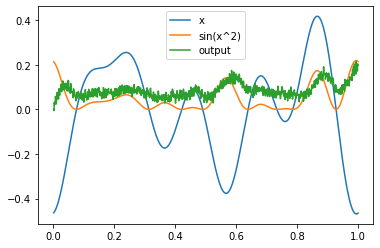

In [14]:
with nengo_dl.Simulator(net, minibatch_size=minibatch_size, seed=seed) as sim:
    sim.compile(
        optimizer=tf.optimizers.Adam(0.01), loss={outpt_p_nofilt: tf.losses.mse}
    )
    sim.fit(inputs, targets, epochs=25)

    sim.run(1.0)
    plot(sim, idx=0)

If we compare this to the figure above, we can see that there has been some improvement.
However, it is better to use a quantitative measure of performance, discussed next.

## Evaluating model performance

As discussed above, the goal with training is usually to reduce some error value.  In
order to evaluate how successful our training has been it is helpful to check what the
value of that error is before and after optimization.  This can be done through the
`sim.evaluate` function.

`sim.evaluate` works very analogously to `sim.fit`; we pass it some data, and it will
compute an error value (based on the loss functions we specified in `sim.compile`).
Note that we can also evaluate loss functions other than those used during training, by
using the `metrics` argument of `sim.compile`.

It is almost always the case that we want to use a different data set for evaluating the
model's performance than we used during training.  Otherwise we might think that
training has improved the performance of our model in general, when in fact it has only
improved performance on that specific training data.  This is known as overfitting.

In [15]:
# create new set of random test data
test_vals = np.random.uniform(-1, 1, size=(1024, 1, 1))

Another important factor to keep in mind is that during training the spiking neurons in
the model are automatically being swapped for differentiable rate neurons.  This is one
of the reasons that we only needed to run the training for a single timestep (rate
neurons compute their output instantaneously, whereas spiking neurons need to accumulate
voltage and spike over time).  By default, `sim.evaluate` does not change the neuron
models in this way.  This is what we want, because it is the performance of the model we
defined, which contains spiking neurons, that we want to evaluate.  However, this does
mean that we need to increase the value of `n_steps` for the testing data.  In addition,
we will use the output probe with the synaptic filter, in order to get a less noisy
estimate of the model's output.

In [16]:
# repeat test data for a number of timesteps
test_steps = 100
test_vals = np.tile(test_vals, (1, test_steps, 1))

# create test data dictionary
# note: using outpt_p instead of outpt_p_nofilt
test_inputs = {inpt: test_vals}
test_targets = {outpt_p: np.sin(test_vals ** 2)}

We'll also define a custom objective function.  The initial output of the model will be
dominated by startup artifacts (e.g., synaptic filter effects), and not indicative of
the model's optimized performance.  So we'll define a version of mean squared error that
only looks at the model's output from the last 10 timesteps, in order to get a more
meaningful measure of how much the performance improves with training.

In [17]:
def test_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred[:, -10:] - y_true[:, -10:]))

Now we are ready to evaluate the model's performance.  We will do the same thing we did
in the training example above, but also evaluate the performance of our model on the
test data before and after training.

In [18]:
with nengo_dl.Simulator(net, minibatch_size=minibatch_size, seed=seed) as sim:
    sim.compile(loss={outpt_p: test_mse})
    print("Error before training:", sim.evaluate(test_inputs, test_targets)["loss"])

    # run the training, same as in the previous section
    print("Training")
    sim.compile(
        optimizer=tf.optimizers.Adam(0.01), loss={outpt_p_nofilt: tf.losses.mse}
    )
    sim.fit(inputs, targets, epochs=25)

    sim.compile(loss={outpt_p: test_mse})
    print("Error after training:", sim.evaluate(test_inputs, test_targets)["loss"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|##############Constructing graph: build stage (46%)             | ETA: 0:00:00

|##############Constructing graph: build stage (80%)             | ETA: 0:00:00

|  #                      Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|##############Constructing graph: build stage (60%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|##############Constructing graph: build stage (60%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

 1/32 [..............................] - ETA: 0s - loss: 0.0039 - probe_1_loss: 0.0039

 2/32 [>.............................] - ETA: 0s - loss: 0.0033 - probe_1_loss: 0.0033

 3/32 [=>............................] - ETA: 1s - loss: 0.0031 - probe_1_loss: 0.0031

 4/32 [==>...........................] - ETA: 1s - loss: 0.0032 - probe_1_loss: 0.0032

 5/32 [===>..........................] - ETA: 1s - loss: 0.0033 - probe_1_loss: 0.0033

 6/32 [====>.........................] - ETA: 1s - loss: 0.0032 - probe_1_loss: 0.0032

 7/32 [=====>........................] - ETA: 1s - loss: 0.0036 - probe_1_loss: 0.0036

 8/32 [======>.......................] - ETA: 1s - loss: 0.0036 - probe_1_loss: 0.0036

 9/32 [=======>......................] - ETA: 1s - loss: 0.0037 - probe_1_loss: 0.0037

10/32 [========>.....................] - ETA: 1s - loss: 0.0040 - probe_1_loss: 0.0040

11/32 [=========>....................] - ETA: 1s - loss: 0.0040 - probe_1_loss: 0.0040

12/32 [==========>...................] - ETA: 1s - loss: 0.0039 - probe_1_loss: 0.0039

13/32 [===========>..................] - ETA: 1s - loss: 0.0040 - probe_1_loss: 0.0040

14/32 [============>.................] - ETA: 1s - loss: 0.0038 - probe_1_loss: 0.0038

15/32 [=============>................] - ETA: 1s - loss: 0.0038 - probe_1_loss: 0.0038

16/32 [==============>...............] - ETA: 1s - loss: 0.0038 - probe_1_loss: 0.0038

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - probe_1_loss: 0.0038

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - probe_1_loss: 0.0038

19/32 [================>.............] - ETA: 0s - loss: 0.0037 - probe_1_loss: 0.0037

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - probe_1_loss: 0.0038

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - probe_1_loss: 0.0038

22/32 [===================>..........] - ETA: 0s - loss: 0.0040 - probe_1_loss: 0.0040

23/32 [====================>.........] - ETA: 0s - loss: 0.0040 - probe_1_loss: 0.0040

24/32 [=====================>........] - ETA: 0s - loss: 0.0040 - probe_1_loss: 0.0040

25/32 [======================>.......] - ETA: 0s - loss: 0.0040 - probe_1_loss: 0.0040

26/32 [=======================>......] - ETA: 0s - loss: 0.0040 - probe_1_loss: 0.0040

27/32 [========================>.....] - ETA: 0s - loss: 0.0040 - probe_1_loss: 0.0040

28/32 [=========================>....] - ETA: 0s - loss: 0.0040 - probe_1_loss: 0.0040

29/32 [==========================>...] - ETA: 0s - loss: 0.0040 - probe_1_loss: 0.0040

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - probe_1_loss: 0.0039

31/32 [============================>.] - ETA: 0s - loss: 0.0040 - probe_1_loss: 0.0040

32/32 [==============================] - ETA: 0s - loss: 0.0040 - probe_1_loss: 0.0040

32/32 [==============================] - 2s 65ms/step - loss: 0.0040 - probe_1_loss: 0.0040


Error before training: 0.003992334473878145
Training
Epoch 1/25
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|##############Constructing graph: build stage (53%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|##############Constructing graph: build stage (53%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

  1/128 [..............................] - ETA: 0s - loss: 0.0014 - probe_2_loss: 0.0014

 12/128 [=>............................] - ETA: 0s - loss: 0.0018 - probe_2_loss: 0.0018

 24/128 [====>.........................] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

 35/128 [=======>......................] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

 46/128 [=========>....................] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

 58/128 [============>.................] - ETA: 0s - loss: 0.0016 - probe_2_loss: 0.0016

 69/128 [===============>..............] - ETA: 0s - loss: 0.0016 - probe_2_loss: 0.0016

 81/128 [=================>............] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

 92/128 [====================>.........] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

104/128 [=======================>......] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

116/128 [==========================>...] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

128/128 [==============================] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

128/128 [==============================] - 1s 5ms/step - loss: 0.0015 - probe_2_loss: 0.0015


Epoch 2/25
  1/128 [..............................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

 13/128 [==>...........................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 24/128 [====>.........................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 35/128 [=======>......................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 47/128 [==========>...................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 58/128 [============>.................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 70/128 [===============>..............] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 82/128 [==================>...........] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 93/128 [====================>.........] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

105/128 [=======================>......] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

116/128 [==========================>...] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

127/128 [============================>.] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

128/128 [==============================] - 1s 5ms/step - loss: 0.0011 - probe_2_loss: 0.0011


Epoch 3/25
  1/128 [..............................] - ETA: 0s - loss: 0.0010 - probe_2_loss: 0.0010

 13/128 [==>...........................] - ETA: 0s - loss: 9.1022e-04 - probe_2_loss: 9.1022e-04

 25/128 [====>.........................] - ETA: 0s - loss: 9.4411e-04 - probe_2_loss: 9.4411e-04

 36/128 [=======>......................] - ETA: 0s - loss: 9.4754e-04 - probe_2_loss: 9.4754e-04

 48/128 [==========>...................] - ETA: 0s - loss: 9.4546e-04 - probe_2_loss: 9.4546e-04

 60/128 [=============>................] - ETA: 0s - loss: 9.2811e-04 - probe_2_loss: 9.2811e-04

 72/128 [===============>..............] - ETA: 0s - loss: 9.1625e-04 - probe_2_loss: 9.1625e-04

 83/128 [==================>...........] - ETA: 0s - loss: 9.1138e-04 - probe_2_loss: 9.1138e-04

 94/128 [=====================>........] - ETA: 0s - loss: 9.1295e-04 - probe_2_loss: 9.1295e-04

106/128 [=======================>......] - ETA: 0s - loss: 8.9344e-04 - probe_2_loss: 8.9344e-04

117/128 [==========================>...] - ETA: 0s - loss: 8.7380e-04 - probe_2_loss: 8.7380e-04

128/128 [==============================] - ETA: 0s - loss: 8.7136e-04 - probe_2_loss: 8.7136e-04

128/128 [==============================] - 1s 5ms/step - loss: 8.7136e-04 - probe_2_loss: 8.7136e-04


Epoch 4/25
  1/128 [..............................] - ETA: 0s - loss: 4.7493e-04 - probe_2_loss: 4.7493e-04

 13/128 [==>...........................] - ETA: 0s - loss: 6.6964e-04 - probe_2_loss: 6.6964e-04

 24/128 [====>.........................] - ETA: 0s - loss: 7.0974e-04 - probe_2_loss: 7.0974e-04

 36/128 [=======>......................] - ETA: 0s - loss: 7.2303e-04 - probe_2_loss: 7.2303e-04

 48/128 [==========>...................] - ETA: 0s - loss: 7.8340e-04 - probe_2_loss: 7.8340e-04

 59/128 [============>.................] - ETA: 0s - loss: 7.8043e-04 - probe_2_loss: 7.8043e-04

 70/128 [===============>..............] - ETA: 0s - loss: 7.5601e-04 - probe_2_loss: 7.5601e-04

 82/128 [==================>...........] - ETA: 0s - loss: 7.4754e-04 - probe_2_loss: 7.4754e-04

 93/128 [====================>.........] - ETA: 0s - loss: 7.3084e-04 - probe_2_loss: 7.3084e-04

104/128 [=======================>......] - ETA: 0s - loss: 7.2044e-04 - probe_2_loss: 7.2044e-04

115/128 [=========================>....] - ETA: 0s - loss: 7.2546e-04 - probe_2_loss: 7.2546e-04

126/128 [============================>.] - ETA: 0s - loss: 7.1525e-04 - probe_2_loss: 7.1525e-04

128/128 [==============================] - 1s 5ms/step - loss: 7.1509e-04 - probe_2_loss: 7.1509e-04


Epoch 5/25
  1/128 [..............................] - ETA: 0s - loss: 7.6410e-04 - probe_2_loss: 7.6410e-04

 13/128 [==>...........................] - ETA: 0s - loss: 6.8703e-04 - probe_2_loss: 6.8703e-04

 24/128 [====>.........................] - ETA: 0s - loss: 6.7202e-04 - probe_2_loss: 6.7202e-04

 35/128 [=======>......................] - ETA: 0s - loss: 6.5684e-04 - probe_2_loss: 6.5684e-04

 47/128 [==========>...................] - ETA: 0s - loss: 6.6722e-04 - probe_2_loss: 6.6722e-04

 59/128 [============>.................] - ETA: 0s - loss: 6.5110e-04 - probe_2_loss: 6.5110e-04

 71/128 [===============>..............] - ETA: 0s - loss: 6.4600e-04 - probe_2_loss: 6.4600e-04

 82/128 [==================>...........] - ETA: 0s - loss: 6.4683e-04 - probe_2_loss: 6.4683e-04

 93/128 [====================>.........] - ETA: 0s - loss: 6.4370e-04 - probe_2_loss: 6.4370e-04

104/128 [=======================>......] - ETA: 0s - loss: 6.2849e-04 - probe_2_loss: 6.2849e-04

116/128 [==========================>...] - ETA: 0s - loss: 6.1798e-04 - probe_2_loss: 6.1798e-04

127/128 [============================>.] - ETA: 0s - loss: 6.1676e-04 - probe_2_loss: 6.1676e-04

128/128 [==============================] - 1s 5ms/step - loss: 6.1673e-04 - probe_2_loss: 6.1673e-04


Epoch 6/25
  1/128 [..............................] - ETA: 0s - loss: 4.8645e-04 - probe_2_loss: 4.8645e-04

 12/128 [=>............................] - ETA: 0s - loss: 4.5115e-04 - probe_2_loss: 4.5115e-04

 24/128 [====>.........................] - ETA: 0s - loss: 5.6467e-04 - probe_2_loss: 5.6467e-04

 36/128 [=======>......................] - ETA: 0s - loss: 5.5422e-04 - probe_2_loss: 5.5422e-04

 48/128 [==========>...................] - ETA: 0s - loss: 5.5352e-04 - probe_2_loss: 5.5352e-04

 59/128 [============>.................] - ETA: 0s - loss: 5.6623e-04 - probe_2_loss: 5.6623e-04

 69/128 [===============>..............] - ETA: 0s - loss: 5.6767e-04 - probe_2_loss: 5.6767e-04

 81/128 [=================>............] - ETA: 0s - loss: 5.7360e-04 - probe_2_loss: 5.7360e-04

 93/128 [====================>.........] - ETA: 0s - loss: 5.7375e-04 - probe_2_loss: 5.7375e-04

104/128 [=======================>......] - ETA: 0s - loss: 5.7169e-04 - probe_2_loss: 5.7169e-04

113/128 [=========================>....] - ETA: 0s - loss: 5.6451e-04 - probe_2_loss: 5.6451e-04

122/128 [===========================>..] - ETA: 0s - loss: 5.6192e-04 - probe_2_loss: 5.6192e-04

128/128 [==============================] - 1s 5ms/step - loss: 5.5997e-04 - probe_2_loss: 5.5997e-04


Epoch 7/25
  1/128 [..............................] - ETA: 0s - loss: 5.4964e-04 - probe_2_loss: 5.4964e-04

 13/128 [==>...........................] - ETA: 0s - loss: 5.2451e-04 - probe_2_loss: 5.2451e-04

 24/128 [====>.........................] - ETA: 0s - loss: 5.0796e-04 - probe_2_loss: 5.0796e-04

 35/128 [=======>......................] - ETA: 0s - loss: 5.1459e-04 - probe_2_loss: 5.1459e-04

 46/128 [=========>....................] - ETA: 0s - loss: 5.2507e-04 - probe_2_loss: 5.2507e-04

 58/128 [============>.................] - ETA: 0s - loss: 5.2152e-04 - probe_2_loss: 5.2152e-04

 66/128 [==============>...............] - ETA: 0s - loss: 5.1914e-04 - probe_2_loss: 5.1914e-04

 77/128 [=================>............] - ETA: 0s - loss: 5.3706e-04 - probe_2_loss: 5.3706e-04

 88/128 [===================>..........] - ETA: 0s - loss: 5.4722e-04 - probe_2_loss: 5.4722e-04

100/128 [======================>.......] - ETA: 0s - loss: 5.3064e-04 - probe_2_loss: 5.3064e-04

111/128 [=========================>....] - ETA: 0s - loss: 5.2572e-04 - probe_2_loss: 5.2572e-04

122/128 [===========================>..] - ETA: 0s - loss: 5.2665e-04 - probe_2_loss: 5.2665e-04

128/128 [==============================] - 1s 5ms/step - loss: 5.2133e-04 - probe_2_loss: 5.2133e-04


Epoch 8/25
  1/128 [..............................] - ETA: 0s - loss: 6.3802e-04 - probe_2_loss: 6.3802e-04

 12/128 [=>............................] - ETA: 0s - loss: 5.1353e-04 - probe_2_loss: 5.1353e-04

 23/128 [====>.........................] - ETA: 0s - loss: 5.1962e-04 - probe_2_loss: 5.1962e-04

 35/128 [=======>......................] - ETA: 0s - loss: 5.1721e-04 - probe_2_loss: 5.1721e-04

 47/128 [==========>...................] - ETA: 0s - loss: 5.0702e-04 - probe_2_loss: 5.0702e-04

 58/128 [============>.................] - ETA: 0s - loss: 5.1502e-04 - probe_2_loss: 5.1502e-04

 69/128 [===============>..............] - ETA: 0s - loss: 4.9944e-04 - probe_2_loss: 4.9944e-04

 81/128 [=================>............] - ETA: 0s - loss: 5.0451e-04 - probe_2_loss: 5.0451e-04

 93/128 [====================>.........] - ETA: 0s - loss: 5.0006e-04 - probe_2_loss: 5.0006e-04

104/128 [=======================>......] - ETA: 0s - loss: 5.0675e-04 - probe_2_loss: 5.0675e-04

115/128 [=========================>....] - ETA: 0s - loss: 5.0345e-04 - probe_2_loss: 5.0345e-04

126/128 [============================>.] - ETA: 0s - loss: 4.9834e-04 - probe_2_loss: 4.9834e-04

128/128 [==============================] - 1s 5ms/step - loss: 4.9686e-04 - probe_2_loss: 4.9686e-04


Epoch 9/25
  1/128 [..............................] - ETA: 0s - loss: 2.5378e-04 - probe_2_loss: 2.5378e-04

 12/128 [=>............................] - ETA: 0s - loss: 4.5942e-04 - probe_2_loss: 4.5942e-04

 23/128 [====>.........................] - ETA: 0s - loss: 5.0621e-04 - probe_2_loss: 5.0621e-04

 35/128 [=======>......................] - ETA: 0s - loss: 5.2095e-04 - probe_2_loss: 5.2095e-04

 47/128 [==========>...................] - ETA: 0s - loss: 5.0971e-04 - probe_2_loss: 5.0971e-04

 59/128 [============>.................] - ETA: 0s - loss: 4.9159e-04 - probe_2_loss: 4.9159e-04

 69/128 [===============>..............] - ETA: 0s - loss: 4.9371e-04 - probe_2_loss: 4.9371e-04

 81/128 [=================>............] - ETA: 0s - loss: 4.8971e-04 - probe_2_loss: 4.8971e-04

 92/128 [====================>.........] - ETA: 0s - loss: 4.8387e-04 - probe_2_loss: 4.8387e-04

104/128 [=======================>......] - ETA: 0s - loss: 4.8291e-04 - probe_2_loss: 4.8291e-04

115/128 [=========================>....] - ETA: 0s - loss: 4.7765e-04 - probe_2_loss: 4.7765e-04

127/128 [============================>.] - ETA: 0s - loss: 4.7799e-04 - probe_2_loss: 4.7799e-04

128/128 [==============================] - 1s 5ms/step - loss: 4.7630e-04 - probe_2_loss: 4.7630e-04


Epoch 10/25
  1/128 [..............................] - ETA: 0s - loss: 5.8436e-04 - probe_2_loss: 5.8436e-04

 13/128 [==>...........................] - ETA: 0s - loss: 3.8286e-04 - probe_2_loss: 3.8286e-04

 25/128 [====>.........................] - ETA: 0s - loss: 4.3336e-04 - probe_2_loss: 4.3336e-04

 36/128 [=======>......................] - ETA: 0s - loss: 4.4419e-04 - probe_2_loss: 4.4419e-04

 47/128 [==========>...................] - ETA: 0s - loss: 4.4247e-04 - probe_2_loss: 4.4247e-04

 58/128 [============>.................] - ETA: 0s - loss: 4.5429e-04 - probe_2_loss: 4.5429e-04

 69/128 [===============>..............] - ETA: 0s - loss: 4.6343e-04 - probe_2_loss: 4.6343e-04

 80/128 [=================>............] - ETA: 0s - loss: 4.6735e-04 - probe_2_loss: 4.6735e-04

 91/128 [====================>.........] - ETA: 0s - loss: 4.6300e-04 - probe_2_loss: 4.6300e-04

103/128 [=======================>......] - ETA: 0s - loss: 4.6074e-04 - probe_2_loss: 4.6074e-04

115/128 [=========================>....] - ETA: 0s - loss: 4.5649e-04 - probe_2_loss: 4.5649e-04

126/128 [============================>.] - ETA: 0s - loss: 4.5501e-04 - probe_2_loss: 4.5501e-04

128/128 [==============================] - 1s 5ms/step - loss: 4.5687e-04 - probe_2_loss: 4.5687e-04


Epoch 11/25
  1/128 [..............................] - ETA: 0s - loss: 8.4476e-04 - probe_2_loss: 8.4476e-04

 12/128 [=>............................] - ETA: 0s - loss: 4.7060e-04 - probe_2_loss: 4.7060e-04

 24/128 [====>.........................] - ETA: 0s - loss: 4.5058e-04 - probe_2_loss: 4.5058e-04

 35/128 [=======>......................] - ETA: 0s - loss: 4.3163e-04 - probe_2_loss: 4.3163e-04

 47/128 [==========>...................] - ETA: 0s - loss: 4.4250e-04 - probe_2_loss: 4.4250e-04

 59/128 [============>.................] - ETA: 0s - loss: 4.5429e-04 - probe_2_loss: 4.5429e-04

 67/128 [==============>...............] - ETA: 0s - loss: 4.4510e-04 - probe_2_loss: 4.4510e-04

 78/128 [=================>............] - ETA: 0s - loss: 4.4092e-04 - probe_2_loss: 4.4092e-04

 89/128 [===================>..........] - ETA: 0s - loss: 4.4423e-04 - probe_2_loss: 4.4423e-04

101/128 [======================>.......] - ETA: 0s - loss: 4.4473e-04 - probe_2_loss: 4.4473e-04

112/128 [=========================>....] - ETA: 0s - loss: 4.4177e-04 - probe_2_loss: 4.4177e-04

123/128 [===========================>..] - ETA: 0s - loss: 4.4376e-04 - probe_2_loss: 4.4376e-04

128/128 [==============================] - 1s 5ms/step - loss: 4.3958e-04 - probe_2_loss: 4.3958e-04


Epoch 12/25
  1/128 [..............................] - ETA: 0s - loss: 4.5329e-04 - probe_2_loss: 4.5329e-04

 13/128 [==>...........................] - ETA: 0s - loss: 4.5173e-04 - probe_2_loss: 4.5173e-04

 24/128 [====>.........................] - ETA: 0s - loss: 4.1811e-04 - probe_2_loss: 4.1811e-04

 35/128 [=======>......................] - ETA: 0s - loss: 4.2209e-04 - probe_2_loss: 4.2209e-04

 46/128 [=========>....................] - ETA: 0s - loss: 4.2182e-04 - probe_2_loss: 4.2182e-04

 57/128 [============>.................] - ETA: 0s - loss: 4.2403e-04 - probe_2_loss: 4.2403e-04

 68/128 [==============>...............] - ETA: 0s - loss: 4.2541e-04 - probe_2_loss: 4.2541e-04

 74/128 [================>.............] - ETA: 0s - loss: 4.2312e-04 - probe_2_loss: 4.2312e-04

 82/128 [==================>...........] - ETA: 0s - loss: 4.2868e-04 - probe_2_loss: 4.2868e-04

 94/128 [=====================>........] - ETA: 0s - loss: 4.2678e-04 - probe_2_loss: 4.2678e-04

106/128 [=======================>......] - ETA: 0s - loss: 4.2923e-04 - probe_2_loss: 4.2923e-04

117/128 [==========================>...] - ETA: 0s - loss: 4.2471e-04 - probe_2_loss: 4.2471e-04

128/128 [==============================] - ETA: 0s - loss: 4.2233e-04 - probe_2_loss: 4.2233e-04

128/128 [==============================] - 1s 5ms/step - loss: 4.2233e-04 - probe_2_loss: 4.2233e-04


Epoch 13/25
  1/128 [..............................] - ETA: 0s - loss: 4.3279e-04 - probe_2_loss: 4.3279e-04

 13/128 [==>...........................] - ETA: 0s - loss: 4.0182e-04 - probe_2_loss: 4.0182e-04

 24/128 [====>.........................] - ETA: 0s - loss: 4.0794e-04 - probe_2_loss: 4.0794e-04

 36/128 [=======>......................] - ETA: 0s - loss: 4.2005e-04 - probe_2_loss: 4.2005e-04

 48/128 [==========>...................] - ETA: 0s - loss: 4.2702e-04 - probe_2_loss: 4.2702e-04

 59/128 [============>.................] - ETA: 0s - loss: 4.3456e-04 - probe_2_loss: 4.3456e-04

 71/128 [===============>..............] - ETA: 0s - loss: 4.3624e-04 - probe_2_loss: 4.3624e-04

 80/128 [=================>............] - ETA: 0s - loss: 4.2805e-04 - probe_2_loss: 4.2805e-04

 91/128 [====================>.........] - ETA: 0s - loss: 4.2054e-04 - probe_2_loss: 4.2054e-04

103/128 [=======================>......] - ETA: 0s - loss: 4.1902e-04 - probe_2_loss: 4.1902e-04

114/128 [=========================>....] - ETA: 0s - loss: 4.1181e-04 - probe_2_loss: 4.1181e-04

125/128 [============================>.] - ETA: 0s - loss: 4.0972e-04 - probe_2_loss: 4.0972e-04

128/128 [==============================] - 1s 5ms/step - loss: 4.0840e-04 - probe_2_loss: 4.0840e-04


Epoch 14/25
  1/128 [..............................] - ETA: 0s - loss: 3.3086e-04 - probe_2_loss: 3.3086e-04

 12/128 [=>............................] - ETA: 0s - loss: 3.5013e-04 - probe_2_loss: 3.5013e-04

 23/128 [====>.........................] - ETA: 0s - loss: 3.6659e-04 - probe_2_loss: 3.6659e-04

 35/128 [=======>......................] - ETA: 0s - loss: 3.8331e-04 - probe_2_loss: 3.8331e-04

 46/128 [=========>....................] - ETA: 0s - loss: 3.7558e-04 - probe_2_loss: 3.7558e-04

 57/128 [============>.................] - ETA: 0s - loss: 3.9040e-04 - probe_2_loss: 3.9040e-04

 68/128 [==============>...............] - ETA: 0s - loss: 3.9211e-04 - probe_2_loss: 3.9211e-04

 79/128 [=================>............] - ETA: 0s - loss: 3.9884e-04 - probe_2_loss: 3.9884e-04

 90/128 [====================>.........] - ETA: 0s - loss: 3.9366e-04 - probe_2_loss: 3.9366e-04

101/128 [======================>.......] - ETA: 0s - loss: 3.9559e-04 - probe_2_loss: 3.9559e-04

112/128 [=========================>....] - ETA: 0s - loss: 3.9414e-04 - probe_2_loss: 3.9414e-04

124/128 [============================>.] - ETA: 0s - loss: 3.9536e-04 - probe_2_loss: 3.9536e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.9668e-04 - probe_2_loss: 3.9668e-04


Epoch 15/25
  1/128 [..............................] - ETA: 0s - loss: 6.1306e-04 - probe_2_loss: 6.1306e-04

 13/128 [==>...........................] - ETA: 0s - loss: 3.9793e-04 - probe_2_loss: 3.9793e-04

 25/128 [====>.........................] - ETA: 0s - loss: 4.1044e-04 - probe_2_loss: 4.1044e-04

 36/128 [=======>......................] - ETA: 0s - loss: 3.9873e-04 - probe_2_loss: 3.9873e-04

 47/128 [==========>...................] - ETA: 0s - loss: 4.1181e-04 - probe_2_loss: 4.1181e-04

 58/128 [============>.................] - ETA: 0s - loss: 4.0072e-04 - probe_2_loss: 4.0072e-04

 70/128 [===============>..............] - ETA: 0s - loss: 3.9944e-04 - probe_2_loss: 3.9944e-04

 81/128 [=================>............] - ETA: 0s - loss: 3.9565e-04 - probe_2_loss: 3.9565e-04

 92/128 [====================>.........] - ETA: 0s - loss: 3.9172e-04 - probe_2_loss: 3.9172e-04

104/128 [=======================>......] - ETA: 0s - loss: 3.9192e-04 - probe_2_loss: 3.9192e-04

116/128 [==========================>...] - ETA: 0s - loss: 3.8817e-04 - probe_2_loss: 3.8817e-04

127/128 [============================>.] - ETA: 0s - loss: 3.9009e-04 - probe_2_loss: 3.9009e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.8904e-04 - probe_2_loss: 3.8904e-04


Epoch 16/25
  1/128 [..............................] - ETA: 0s - loss: 3.1620e-04 - probe_2_loss: 3.1620e-04

 13/128 [==>...........................] - ETA: 0s - loss: 4.4397e-04 - probe_2_loss: 4.4397e-04

 24/128 [====>.........................] - ETA: 0s - loss: 4.1960e-04 - probe_2_loss: 4.1960e-04

 36/128 [=======>......................] - ETA: 0s - loss: 4.0760e-04 - probe_2_loss: 4.0760e-04

 48/128 [==========>...................] - ETA: 0s - loss: 4.0649e-04 - probe_2_loss: 4.0649e-04

 59/128 [============>.................] - ETA: 0s - loss: 3.9786e-04 - probe_2_loss: 3.9786e-04

 70/128 [===============>..............] - ETA: 0s - loss: 3.9367e-04 - probe_2_loss: 3.9367e-04

 82/128 [==================>...........] - ETA: 0s - loss: 3.8358e-04 - probe_2_loss: 3.8358e-04

 94/128 [=====================>........] - ETA: 0s - loss: 3.8530e-04 - probe_2_loss: 3.8530e-04

106/128 [=======================>......] - ETA: 0s - loss: 3.8312e-04 - probe_2_loss: 3.8312e-04

117/128 [==========================>...] - ETA: 0s - loss: 3.8232e-04 - probe_2_loss: 3.8232e-04

127/128 [============================>.] - ETA: 0s - loss: 3.8061e-04 - probe_2_loss: 3.8061e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.8037e-04 - probe_2_loss: 3.8037e-04


Epoch 17/25
  1/128 [..............................] - ETA: 0s - loss: 5.9635e-04 - probe_2_loss: 5.9635e-04

 12/128 [=>............................] - ETA: 0s - loss: 4.0052e-04 - probe_2_loss: 4.0052e-04

 24/128 [====>.........................] - ETA: 0s - loss: 3.6837e-04 - probe_2_loss: 3.6837e-04

 36/128 [=======>......................] - ETA: 0s - loss: 3.7633e-04 - probe_2_loss: 3.7633e-04

 47/128 [==========>...................] - ETA: 0s - loss: 3.6988e-04 - probe_2_loss: 3.6988e-04

 58/128 [============>.................] - ETA: 0s - loss: 3.7842e-04 - probe_2_loss: 3.7842e-04

 70/128 [===============>..............] - ETA: 0s - loss: 3.7622e-04 - probe_2_loss: 3.7622e-04

 81/128 [=================>............] - ETA: 0s - loss: 3.7001e-04 - probe_2_loss: 3.7001e-04

 92/128 [====================>.........] - ETA: 0s - loss: 3.7194e-04 - probe_2_loss: 3.7194e-04

103/128 [=======================>......] - ETA: 0s - loss: 3.7006e-04 - probe_2_loss: 3.7006e-04

115/128 [=========================>....] - ETA: 0s - loss: 3.7274e-04 - probe_2_loss: 3.7274e-04

127/128 [============================>.] - ETA: 0s - loss: 3.7193e-04 - probe_2_loss: 3.7193e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.7131e-04 - probe_2_loss: 3.7131e-04


Epoch 18/25
  1/128 [..............................] - ETA: 0s - loss: 4.8040e-04 - probe_2_loss: 4.8040e-04

 13/128 [==>...........................] - ETA: 0s - loss: 3.7826e-04 - probe_2_loss: 3.7826e-04

 25/128 [====>.........................] - ETA: 0s - loss: 3.8202e-04 - probe_2_loss: 3.8202e-04

 36/128 [=======>......................] - ETA: 0s - loss: 3.6544e-04 - probe_2_loss: 3.6544e-04

 47/128 [==========>...................] - ETA: 0s - loss: 3.6810e-04 - probe_2_loss: 3.6810e-04

 58/128 [============>.................] - ETA: 0s - loss: 3.6737e-04 - probe_2_loss: 3.6737e-04

 69/128 [===============>..............] - ETA: 0s - loss: 3.6448e-04 - probe_2_loss: 3.6448e-04

 81/128 [=================>............] - ETA: 0s - loss: 3.6093e-04 - probe_2_loss: 3.6093e-04

 92/128 [====================>.........] - ETA: 0s - loss: 3.6924e-04 - probe_2_loss: 3.6924e-04

103/128 [=======================>......] - ETA: 0s - loss: 3.6781e-04 - probe_2_loss: 3.6781e-04

114/128 [=========================>....] - ETA: 0s - loss: 3.6908e-04 - probe_2_loss: 3.6908e-04

125/128 [============================>.] - ETA: 0s - loss: 3.6444e-04 - probe_2_loss: 3.6444e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.6397e-04 - probe_2_loss: 3.6397e-04


Epoch 19/25
  1/128 [..............................] - ETA: 0s - loss: 3.8487e-04 - probe_2_loss: 3.8487e-04

 12/128 [=>............................] - ETA: 0s - loss: 3.6116e-04 - probe_2_loss: 3.6116e-04

 23/128 [====>.........................] - ETA: 0s - loss: 3.4948e-04 - probe_2_loss: 3.4948e-04

 34/128 [======>.......................] - ETA: 0s - loss: 3.6186e-04 - probe_2_loss: 3.6186e-04

 46/128 [=========>....................] - ETA: 0s - loss: 3.5804e-04 - probe_2_loss: 3.5804e-04

 58/128 [============>.................] - ETA: 0s - loss: 3.4836e-04 - probe_2_loss: 3.4836e-04

 69/128 [===============>..............] - ETA: 0s - loss: 3.5890e-04 - probe_2_loss: 3.5890e-04

 81/128 [=================>............] - ETA: 0s - loss: 3.5508e-04 - probe_2_loss: 3.5508e-04

 91/128 [====================>.........] - ETA: 0s - loss: 3.5592e-04 - probe_2_loss: 3.5592e-04

103/128 [=======================>......] - ETA: 0s - loss: 3.5365e-04 - probe_2_loss: 3.5365e-04

114/128 [=========================>....] - ETA: 0s - loss: 3.5176e-04 - probe_2_loss: 3.5176e-04

125/128 [============================>.] - ETA: 0s - loss: 3.5379e-04 - probe_2_loss: 3.5379e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.5360e-04 - probe_2_loss: 3.5360e-04


Epoch 20/25
  1/128 [..............................] - ETA: 0s - loss: 4.2278e-04 - probe_2_loss: 4.2278e-04

 13/128 [==>...........................] - ETA: 0s - loss: 3.5699e-04 - probe_2_loss: 3.5699e-04

 25/128 [====>.........................] - ETA: 0s - loss: 3.5961e-04 - probe_2_loss: 3.5961e-04

 37/128 [=======>......................] - ETA: 0s - loss: 3.6788e-04 - probe_2_loss: 3.6788e-04

 48/128 [==========>...................] - ETA: 0s - loss: 3.6233e-04 - probe_2_loss: 3.6233e-04

 59/128 [============>.................] - ETA: 0s - loss: 3.5810e-04 - probe_2_loss: 3.5810e-04

 71/128 [===============>..............] - ETA: 0s - loss: 3.5632e-04 - probe_2_loss: 3.5632e-04

 83/128 [==================>...........] - ETA: 0s - loss: 3.5403e-04 - probe_2_loss: 3.5403e-04

 94/128 [=====================>........] - ETA: 0s - loss: 3.5020e-04 - probe_2_loss: 3.5020e-04

106/128 [=======================>......] - ETA: 0s - loss: 3.5051e-04 - probe_2_loss: 3.5051e-04

117/128 [==========================>...] - ETA: 0s - loss: 3.5186e-04 - probe_2_loss: 3.5186e-04

128/128 [==============================] - ETA: 0s - loss: 3.4732e-04 - probe_2_loss: 3.4732e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.4732e-04 - probe_2_loss: 3.4732e-04


Epoch 21/25
  1/128 [..............................] - ETA: 0s - loss: 3.5586e-04 - probe_2_loss: 3.5586e-04

 12/128 [=>............................] - ETA: 0s - loss: 3.7045e-04 - probe_2_loss: 3.7045e-04

 23/128 [====>.........................] - ETA: 0s - loss: 3.4231e-04 - probe_2_loss: 3.4231e-04

 34/128 [======>.......................] - ETA: 0s - loss: 3.5034e-04 - probe_2_loss: 3.5034e-04

 45/128 [=========>....................] - ETA: 0s - loss: 3.5452e-04 - probe_2_loss: 3.5452e-04

 56/128 [============>.................] - ETA: 0s - loss: 3.5103e-04 - probe_2_loss: 3.5103e-04

 67/128 [==============>...............] - ETA: 0s - loss: 3.4146e-04 - probe_2_loss: 3.4146e-04

 78/128 [=================>............] - ETA: 0s - loss: 3.4205e-04 - probe_2_loss: 3.4205e-04

 89/128 [===================>..........] - ETA: 0s - loss: 3.4124e-04 - probe_2_loss: 3.4124e-04

100/128 [======================>.......] - ETA: 0s - loss: 3.3854e-04 - probe_2_loss: 3.3854e-04

111/128 [=========================>....] - ETA: 0s - loss: 3.3993e-04 - probe_2_loss: 3.3993e-04

122/128 [===========================>..] - ETA: 0s - loss: 3.3868e-04 - probe_2_loss: 3.3868e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.3783e-04 - probe_2_loss: 3.3783e-04


Epoch 22/25
  1/128 [..............................] - ETA: 0s - loss: 2.0359e-04 - probe_2_loss: 2.0359e-04

 12/128 [=>............................] - ETA: 0s - loss: 2.9496e-04 - probe_2_loss: 2.9496e-04

 23/128 [====>.........................] - ETA: 0s - loss: 3.0281e-04 - probe_2_loss: 3.0281e-04

 34/128 [======>.......................] - ETA: 0s - loss: 3.1054e-04 - probe_2_loss: 3.1054e-04

 45/128 [=========>....................] - ETA: 0s - loss: 3.1512e-04 - probe_2_loss: 3.1512e-04

 56/128 [============>.................] - ETA: 0s - loss: 3.2607e-04 - probe_2_loss: 3.2607e-04

 67/128 [==============>...............] - ETA: 0s - loss: 3.2125e-04 - probe_2_loss: 3.2125e-04

 78/128 [=================>............] - ETA: 0s - loss: 3.2357e-04 - probe_2_loss: 3.2357e-04

 89/128 [===================>..........] - ETA: 0s - loss: 3.2244e-04 - probe_2_loss: 3.2244e-04

100/128 [======================>.......] - ETA: 0s - loss: 3.2283e-04 - probe_2_loss: 3.2283e-04

110/128 [========================>.....] - ETA: 0s - loss: 3.2922e-04 - probe_2_loss: 3.2922e-04

120/128 [===========================>..] - ETA: 0s - loss: 3.3001e-04 - probe_2_loss: 3.3001e-04

128/128 [==============================] - ETA: 0s - loss: 3.3009e-04 - probe_2_loss: 3.3009e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.3009e-04 - probe_2_loss: 3.3009e-04


Epoch 23/25
  1/128 [..............................] - ETA: 0s - loss: 2.0556e-04 - probe_2_loss: 2.0556e-04

 12/128 [=>............................] - ETA: 0s - loss: 3.0713e-04 - probe_2_loss: 3.0713e-04

 23/128 [====>.........................] - ETA: 0s - loss: 3.2077e-04 - probe_2_loss: 3.2077e-04

 35/128 [=======>......................] - ETA: 0s - loss: 3.2491e-04 - probe_2_loss: 3.2491e-04

 46/128 [=========>....................] - ETA: 0s - loss: 3.2490e-04 - probe_2_loss: 3.2490e-04

 58/128 [============>.................] - ETA: 0s - loss: 3.2556e-04 - probe_2_loss: 3.2556e-04

 69/128 [===============>..............] - ETA: 0s - loss: 3.2793e-04 - probe_2_loss: 3.2793e-04

 81/128 [=================>............] - ETA: 0s - loss: 3.2637e-04 - probe_2_loss: 3.2637e-04

 92/128 [====================>.........] - ETA: 0s - loss: 3.2775e-04 - probe_2_loss: 3.2775e-04

103/128 [=======================>......] - ETA: 0s - loss: 3.2860e-04 - probe_2_loss: 3.2860e-04

115/128 [=========================>....] - ETA: 0s - loss: 3.2614e-04 - probe_2_loss: 3.2614e-04

127/128 [============================>.] - ETA: 0s - loss: 3.2115e-04 - probe_2_loss: 3.2115e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.2127e-04 - probe_2_loss: 3.2127e-04


Epoch 24/25
  1/128 [..............................] - ETA: 0s - loss: 4.5468e-04 - probe_2_loss: 4.5468e-04

 13/128 [==>...........................] - ETA: 0s - loss: 2.9702e-04 - probe_2_loss: 2.9702e-04

 24/128 [====>.........................] - ETA: 0s - loss: 3.0559e-04 - probe_2_loss: 3.0559e-04

 35/128 [=======>......................] - ETA: 0s - loss: 3.0517e-04 - probe_2_loss: 3.0517e-04

 47/128 [==========>...................] - ETA: 0s - loss: 3.0806e-04 - probe_2_loss: 3.0806e-04

 58/128 [============>.................] - ETA: 0s - loss: 3.0624e-04 - probe_2_loss: 3.0624e-04

 69/128 [===============>..............] - ETA: 0s - loss: 3.1010e-04 - probe_2_loss: 3.1010e-04

 80/128 [=================>............] - ETA: 0s - loss: 3.0950e-04 - probe_2_loss: 3.0950e-04

 91/128 [====================>.........] - ETA: 0s - loss: 3.0869e-04 - probe_2_loss: 3.0869e-04

102/128 [======================>.......] - ETA: 0s - loss: 3.1381e-04 - probe_2_loss: 3.1381e-04

114/128 [=========================>....] - ETA: 0s - loss: 3.0933e-04 - probe_2_loss: 3.0933e-04

126/128 [============================>.] - ETA: 0s - loss: 3.0962e-04 - probe_2_loss: 3.0962e-04

128/128 [==============================] - 1s 5ms/step - loss: 3.0876e-04 - probe_2_loss: 3.0876e-04


Epoch 25/25
  1/128 [..............................] - ETA: 0s - loss: 1.8391e-04 - probe_2_loss: 1.8391e-04

 12/128 [=>............................] - ETA: 0s - loss: 2.4993e-04 - probe_2_loss: 2.4993e-04

 23/128 [====>.........................] - ETA: 0s - loss: 2.8070e-04 - probe_2_loss: 2.8070e-04

 35/128 [=======>......................] - ETA: 0s - loss: 2.8636e-04 - probe_2_loss: 2.8636e-04

 46/128 [=========>....................] - ETA: 0s - loss: 2.9328e-04 - probe_2_loss: 2.9328e-04

 57/128 [============>.................] - ETA: 0s - loss: 2.9150e-04 - probe_2_loss: 2.9150e-04

 68/128 [==============>...............] - ETA: 0s - loss: 2.9513e-04 - probe_2_loss: 2.9513e-04

 79/128 [=================>............] - ETA: 0s - loss: 2.9921e-04 - probe_2_loss: 2.9921e-04

 90/128 [====================>.........] - ETA: 0s - loss: 3.0244e-04 - probe_2_loss: 3.0244e-04

102/128 [======================>.......] - ETA: 0s - loss: 3.0042e-04 - probe_2_loss: 3.0042e-04

114/128 [=========================>....] - ETA: 0s - loss: 2.9757e-04 - probe_2_loss: 2.9757e-04

125/128 [============================>.] - ETA: 0s - loss: 2.9862e-04 - probe_2_loss: 2.9862e-04

128/128 [==============================] - 1s 5ms/step - loss: 2.9722e-04 - probe_2_loss: 2.9722e-04


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|##############Constructing graph: build stage (60%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|##############Constructing graph: build stage (53%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

 1/32 [..............................] - ETA: 0s - loss: 0.0027 - probe_1_loss: 0.0027

 2/32 [>.............................] - ETA: 0s - loss: 0.0023 - probe_1_loss: 0.0023

 3/32 [=>............................] - ETA: 1s - loss: 0.0021 - probe_1_loss: 0.0021

 4/32 [==>...........................] - ETA: 1s - loss: 0.0022 - probe_1_loss: 0.0022

 5/32 [===>..........................] - ETA: 1s - loss: 0.0024 - probe_1_loss: 0.0024

 6/32 [====>.........................] - ETA: 1s - loss: 0.0024 - probe_1_loss: 0.0024

 7/32 [=====>........................] - ETA: 1s - loss: 0.0028 - probe_1_loss: 0.0028

 8/32 [======>.......................] - ETA: 1s - loss: 0.0028 - probe_1_loss: 0.0028

 9/32 [=======>......................] - ETA: 1s - loss: 0.0029 - probe_1_loss: 0.0029

10/32 [========>.....................] - ETA: 1s - loss: 0.0032 - probe_1_loss: 0.0032

11/32 [=========>....................] - ETA: 1s - loss: 0.0031 - probe_1_loss: 0.0031

12/32 [==========>...................] - ETA: 1s - loss: 0.0030 - probe_1_loss: 0.0030

13/32 [===========>..................] - ETA: 1s - loss: 0.0030 - probe_1_loss: 0.0030

14/32 [============>.................] - ETA: 1s - loss: 0.0029 - probe_1_loss: 0.0029

15/32 [=============>................] - ETA: 1s - loss: 0.0029 - probe_1_loss: 0.0029

16/32 [==============>...............] - ETA: 1s - loss: 0.0029 - probe_1_loss: 0.0029

17/32 [==============>...............] - ETA: 0s - loss: 0.0029 - probe_1_loss: 0.0029

18/32 [===============>..............] - ETA: 0s - loss: 0.0029 - probe_1_loss: 0.0029

19/32 [================>.............] - ETA: 0s - loss: 0.0029 - probe_1_loss: 0.0029

20/32 [=================>............] - ETA: 0s - loss: 0.0029 - probe_1_loss: 0.0029

21/32 [==================>...........] - ETA: 0s - loss: 0.0030 - probe_1_loss: 0.0030

22/32 [===================>..........] - ETA: 0s - loss: 0.0030 - probe_1_loss: 0.0030

23/32 [====================>.........] - ETA: 0s - loss: 0.0031 - probe_1_loss: 0.0031

24/32 [=====================>........] - ETA: 0s - loss: 0.0030 - probe_1_loss: 0.0030

25/32 [======================>.......] - ETA: 0s - loss: 0.0030 - probe_1_loss: 0.0030

26/32 [=======================>......] - ETA: 0s - loss: 0.0030 - probe_1_loss: 0.0030

27/32 [========================>.....] - ETA: 0s - loss: 0.0030 - probe_1_loss: 0.0030

28/32 [=========================>....] - ETA: 0s - loss: 0.0030 - probe_1_loss: 0.0030

29/32 [==========================>...] - ETA: 0s - loss: 0.0030 - probe_1_loss: 0.0030

30/32 [===========================>..] - ETA: 0s - loss: 0.0030 - probe_1_loss: 0.0030

31/32 [============================>.] - ETA: 0s - loss: 0.0030 - probe_1_loss: 0.0030

32/32 [==============================] - ETA: 0s - loss: 0.0030 - probe_1_loss: 0.0030

32/32 [==============================] - 2s 65ms/step - loss: 0.0030 - probe_1_loss: 0.0030


Error after training: 0.002971174893900752


We can now say with more confidence that optimizing the encoders and biases has improved
the accuracy of the model.

## Integrating TensorFlow code

Another important feature of NengoDL is the ability to add TensorFlow code into a Nengo
model.  For example, we could use a convolutional vision network, defined in TensorFlow,
as the input to a cognitive Nengo model.  However, we'll keep things simple in this
example and just use TensorFlow to compute the exponent of our output (so that overall
the network is computing $e^{\sin(x^2)}$).  Note that for something like this we don't
really need to use TensorFlow; we can accomplish the same thing with normal Nengo
syntax.  The goal here is just to introduce the methodology in a simple case; see [this
example](https://www.nengo.ai/nengo-dl/examples/pretrained-model.html) for a more
practical example of integrating TensorFlow code in NengoDL.

TensorFlow code is inserted using `TensorNodes`.  A `TensorNode` works much the same way
as a regular `nengo.Node`, except that instead of specifying the Node output using
Python/NumPy functions, we use TensorFlow functions.

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###           Constructing graph: build stage (5%)              | ETA: 0:00:00

|##############Constructing graph: build stage (26%)             | ETA: 0:00:00

|##############Constructing graph: build stage (52%)             | ETA: 0:00:00

|##############Constructing graph: build stage (63%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|   #                     Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

| #                           Simulating                              | 0:00:00

|###           Constructing graph: build stage (5%)              | ETA: 0:00:01

|##############Constructing graph: build stage (26%)             | ETA: 0:00:00

|  #                          Simulating                              | 0:00:00

|##############Constructing graph: build stage (57%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|   #                         Simulating                              | 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

|          #                  Simulating                              | 0:00:01

|           #                 Simulating                              | 0:00:01

|            #                Simulating                              | 0:00:01

|             #               Simulating                              | 0:00:01

|              #              Simulating                              | 0:00:01

|               #             Simulating                              | 0:00:01

|                #            Simulating                              | 0:00:01

|                 #           Simulating                              | 0:00:01

|                  #          Simulating                              | 0:00:01

Simulation finished in 0:00:01                                                 

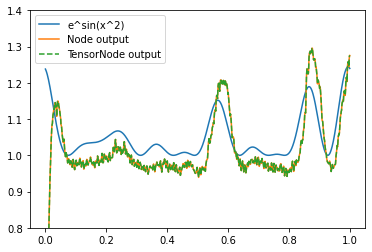

In [19]:
with net:
    # here is how we would accomplish this with a regular nengo Node
    exp_np = nengo.Node(lambda t, x: np.exp(x), size_in=1)
    nengo.Connection(sin, exp_np)
    np_probe = nengo.Probe(exp_np, synapse=0.01)

    # here is how we do the same using a TensorNode
    exp_tf = nengo_dl.TensorNode(lambda t, x: tf.exp(x), shape_in=(1,))
    nengo.Connection(sin, exp_tf)
    tf_probe = nengo.Probe(exp_tf, synapse=0.01)

with nengo_dl.Simulator(net, seed=seed) as sim:
    sim.run(1.0)

plt.figure()
plt.plot(sim.trange(), np.exp(np.sin(sim.data[inpt_p] ** 2)), label="e^sin(x^2)")
plt.plot(sim.trange(), sim.data[np_probe], label="Node output")
plt.plot(sim.trange(), sim.data[tf_probe], label="TensorNode output", linestyle="--")
plt.ylim([0.8, 1.4])
plt.legend()
plt.show()

We can see that the `nengo.Node` and `nengo_dl.TensorNode` are producing the same
output, as we would expect.  But under the hood, one is being computed in NumPy and the
other is being computed in TensorFlow.

More details on TensorNode usage can be found in [the user
guide](https://www.nengo.ai/nengo-dl/tensor-node.html).

## Conclusion

In this tutorial we have introduced the NengoDL Simulator, batch processing, dynamically
specifying input values, optimizing model parameters using deep learning methods, and
integrating TensorFlow code into a Nengo model.  This will allow you to begin to take
advantage of the new features NengoDL adds to the Nengo toolkit.  However, there is much
more functionality in NengoDL than we are able to introduce here; check out the [user
guide](https://www.nengo.ai/nengo-dl/user-guide.html) or [other
examples](https://www.nengo.ai/nengo-dl/examples.html) for more information.